# Setup 

In [1]:
!pip install gym_minigrid
!pip install stable_baselines3
!pip install --upgrade --quiet cloudpickle pickle5
!pip install wandb

     |████████████████████████████████| 47 kB 1.5 MB/s 
     |████████████████████████████████| 176 kB 5.0 MB/s 
     |████████████████████████████████| 256 kB 7.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 142 kB 67.0 MB/s 
     |████████████████████████████████| 97 kB 8.1 MB/s 
     |████████████████████████████████| 180 kB 63.5 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=893c36f920721c7d7e4bcefceb0c233e6b8eee3e49c1fdeec73d78c4db162c0d
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
 

In [2]:
from gym_minigrid.wrappers import *
from gym_minigrid.minigrid import *
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

import torch.nn as nn
import numpy as np
import shutil #to remove folder

import itertools
import random

import matplotlib.pyplot as plt

import wandb
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecVideoRecorder
from wandb.integration.sb3 import WandbCallback

%matplotlib notebook

custom_objects = {
    "lr_schedule": lambda x: .003,
    "clip_range": lambda x: .02
}

import imageio as iio
import os

In [3]:
def save_gif2(gif_name, max_frames, max_episodes, model, env, log_to_wb = True):
    agent1_actions = {
    0: 'Turn left', 1: 'Turn right', 2: 'Move forward',
    3: 'Pickup', 4: 'Drop', 5:'Toggle', 6: 'Done'
    }
    agent2_actions = {
        0: 'Original env', 1: 'Switch left-right'
    }
    
    path = 'gif'

    #remove folder as might contain old files
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

  # Create a new directory 
    os.makedirs(path)

    images = []
    gif_path = gif_name + ".gif"
    frames_path = path+"/"+gif_name+"{j}.jpg"


    j = 0
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10, 5));
    for i in range(max_episodes):
        obs = env.reset()
        if i == 0:
            img1 = ax1.imshow(env.render(pov='agent', highlight=False))
            img2 = ax2.imshow(env.render(pov='original', highlight=False))
        else:
            img1.set_data(env.render(pov='agent', highlight=False))
            img2.set_data(env.render(pov='original', highlight=False))
            
        while True and j < max_frames:
            action, _ = model.predict(obs)
            obs, r, done ,_ = env.step(action)
            img1.set_data(env.render(pov='agent', highlight=False))
            img2.set_data(env.render(pov='original', highlight=False))
            fig.suptitle(f'Reward: {r:.5f}', fontsize=16, y=1)
            ax1.set_title(f"Agent 1: {agent1_actions[env.environment_action]}")
            ax2.set_title(f"Agent 2: {agent2_actions[action]} ")
            fig.canvas.draw()
            fig.savefig(frames_path.format(j=j))
            j=j+1 
            if done: 
                break
    
    with iio.get_writer(gif_path, mode='I') as writer:
        for j in range(max_frames):
            try:
                writer.append_data(iio.imread(frames_path.format(j=j)))
            except OSError as e:
                None
    if log_to_wb == True:
        wandb.log({gif_name: wandb.Video(gif_path)})

In [4]:
def save_gif3(gif_name, max_frames, max_episodes, model, env, log_to_wb = True):

    path = 'gif'

    #remove folder as might contain old files
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

  # Create a new directory 
    os.makedirs(path)

    images = []
    gif_path = gif_name + ".gif"
    frames_path = path+"/"+gif_name+"{j}.jpg"


    j = 0
    obs = env.reset()
    img = env.render(mode='rgb_array', highlight=False)
    for i in range(max_episodes):
        obs = env.reset()
        while True and j < max_frames:
            action, _ = model.predict(obs)
            obs, r, done ,_ = env.step(action)
            fig,(ax1) = plt.subplots(1,1, figsize=(5, 5));
            image1 = ax1.imshow(env.render("rgb_array", highlight=False))
            ax1.set_title(f"Hacked obs: Action = {action}, Reward = {r}, \n Done = {done}")
            plt.savefig(frames_path.format(j=j))
            plt.cla()
            j=j+1 
            if done: 
                break
    with iio.get_writer(gif_path, mode='I') as writer:
        for j in range(max_frames):
            try:
                writer.append_data(iio.imread(frames_path.format(j=j)))
            except OSError as e:
                None
    if log_to_wb == True:
        wandb.log({gif_name: wandb.Video(gif_path)})

In [5]:
# Create gif out of environment and agent. Possibly upload to W&B
# gif_name: ["hacked", "initial_changed_env"] (have mappings in W&B) or custom
def save_gif(gif_name, max_frames, max_episodes, model, env, log_to_wb = True):

  path = 'gif'

  #remove folder as might contain old files
  try:
    shutil.rmtree(path)
  except OSError as e:
      print ("Error: %s - %s." % (e.filename, e.strerror))

  # Create a new directory 
  os.makedirs(path)

  images = []
  gif_path = gif_name + ".gif"
  frames_path = path+"/"+gif_name+"{j}.jpg"

  j = 0
  obs = env.reset()
  img = env.render(pov='agent', highlight=False)
  img2 = env.render(pov='original', highlight=False)


  for i in range(max_episodes):
      obs = env.reset()
      while True and j < max_frames:
        action, _ = model.predict(obs)

        obs, r, done ,_ = env.step(action)


        fig,(ax1, ax2) = plt.subplots(1,1, figsize=(5, 5));
        
        image1 = ax1.imshow(env.render(pov= "original", highlight=False))
        image2 = ax2.imshow(env.render(pov = "agent", highlight=False))
        ax1.set_title(f"Initial obs: Action = {env.environment_action}, Reward = {r}, \n Done = {done}")
        ax2.set_title(f"Hacked obs: Action = {env.transformation_action}, Reward = {r}, \n Done = {done}")
        plt.savefig(frames_path.format(j=j))
        plt.cla()
        j=j+1 
        if done: 
          break
  with iio.get_writer(gif_path, mode='I') as writer:
      for j in range(max_frames):
          try:
            writer.append_data(iio.imread(frames_path.format(j=j)))
          except OSError as e:
            None
  if log_to_wb == True:
    wandb.log({gif_name: wandb.Video(gif_path)})

In [6]:
#Vanilla environment for first agent
class EmptyBallRoom(MiniGridEnv):
    def __init__(self, size=9, ball_color="green", tile_size=8):
        self.ball_color = ball_color
        self.tile_size = tile_size
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(size * tile_size, size * tile_size, 3),
            dtype='uint8'
        )
    
    def reset(self):
        super().reset()
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        return rgb_observation
        
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)
        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"

    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True
        
        rgb_observation = self.render("rgb_image", highlight=False, tile_size=self.tile_size)
        
        return rgb_observation, reward, done, info

In [7]:
#Vanilla environment for first agent
class ObsLeftRightSwitchWrapper(MiniGridEnv):
    def __init__(self, size=9, ball_color="green", tile_size=8):
        self.ball_color = ball_color
        self.tile_size = tile_size
        super().__init__(
            grid_size=size,
            max_steps=4*size*size,
            # Set this to True for maximum speed
            see_through_walls=True
        )
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(size * tile_size, size * tile_size, 3),
            dtype='uint8'
        )
    
    def reset(self):
        super().reset()
        #rgb_observation = np.rot90(self.render("rgb_image", highlight=False, tile_size=self.tile_size),k=1, axes=(1,0)).copy()
        rgb_observation = np.fliplr(self.render("rgb_image", highlight=False, tile_size=self.tile_size)).copy()

        return rgb_observation
        
    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)
        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place the agent
        # self.agent_pos = (1, 1)
        # self.agent_dir=0
        self.place_agent()
        
        # Place object
        self.ball = Ball(self.ball_color)
        # self.put_obj(self.ball, width-2, height-2)
        self.place_obj(self.ball)
        self.mission = f"Pick up {self.ball_color} {self.ball.type}"

    def step(self, action):
        obs, reward, done, info = super().step(action)

        if action == self.actions.pickup:
            if self.carrying and self.carrying == self.ball:
                reward = self._reward()
                done = True
        
        #rgb_observation = np.rot90(self.render("rgb_image", highlight=False, tile_size=self.tile_size), k=1, axes=(1,0)).copy()
        rgb_observation = np.fliplr(self.render("rgb_image", highlight=False, tile_size=self.tile_size)).copy()
        
        return rgb_observation, reward, done, info
    def renderLR(self):
        observation = np.fliplr(self.render("rgb_image", highlight=False, tile_size=self.tile_size)).copy()

        return observation

In [8]:
# Hacked environment wrapper
class HackedLREnvironment(gym.core.Wrapper):
    
    def __init__(self, env, first_agent):
        self.first_agent = first_agent
        super().__init__(env)
        self.action_space = spaces.Discrete(2) #1 discrete action
        
        self.transformed_obs = np.array([])
        self.original_obs = np.array([])
        
        self.transformation_action = None
        self.environment_action = None
        
        self.reset()
        
    def reset(self):
        self.env.reset()
        self.original_ball_color = self.env.ball.color
        self.original_obs = self.transformed_obs = self.env.renderLR().copy()
        self.transformation_action
        return self.original_obs

    
    def step(self, first_action):
        """
        Can flip left and right 
        """
        self.transformation_action = first_action

        if first_action == 1: #flip left and right
            #self.transformed_obs = np.fliplr(self.env.render("rgb_image", highlight=False, tile_size=self.env.tile_size)).copy()
            self.transformed_obs = np.fliplr(self.env.renderLR()).copy()
        elif first_action == 0:
            #self.transformed_obs = self.env.render("rgb_image", highlight=False, tile_size=self.env.tile_size)
            self.transformed_obs = self.env.renderLR().copy()
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(first_action))
            
     
        second_action, _ = self.first_agent.predict(self.transformed_obs)

        self.environment_action = second_action

        self.original_obs, reward, done, info = self.env.step(second_action)
        
        return self.original_obs, reward, done, info
        
    def render(self, pov="agent", highlight=False, **kwargs):
        """
        pov : agent / original
        """
        if pov=="agent":
            if(self.transformation_action == 0):
                return self.render(pov='original')
            else:
              observation = self.env.render(highlight=highlight, **kwargs)#np.fliplr(self.env.renderLR()).copy() #np.fliplr(self.env.render(highlight=highlight, **kwargs))
        else:
            observation = np.fliplr(self.env.render(highlight=highlight, **kwargs)).copy() #self.env.render(highlight=highlight, **kwargs)

        return observation

In [8]:
############### TESTING

def train_2nd_agent_and_validate_test(trial_description, trial_name, config, modelName = "first_agent", randomColor = False, log_wb=False):
  ### Initiate W&B connection
  project_name = "learning-by-hacking"
  # if log_wb:
  #   run = wandb.init(
  #     project=project_name,
  #     entity="learning-by-hacking",
  #     name = trial_name,
  #     config=config,
  #     sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
  #     monitor_gym=True,  # auto-upload the videos of agents playing the game
  #     save_code=True,  # optional
  #   )

  ### Load agent
  first_agent = PPO.load(modelName, custom_objects=custom_objects)
  print("loaded:", "gamma =", first_agent.gamma, "n_steps =", first_agent.n_steps)

  ############################################################################################################## 
  # Only this section is expected to get changed per different experiments

  ### choose random color or not
  second_env_kwargs = {"size": config["ROOM_SIZE"], "ball_color": config["2ND_BALL_COLOR"], "tile_size": config["TILE_SIZE"]} 
  second_env =ObsLeftRightSwitchWrapper(**second_env_kwargs)
  
  ## vectorize for training
  second_env_vector = make_vec_env(
    HackedLREnvironment,
    n_envs=2,                           # max 2 for colaboratory
    vec_env_cls=SubprocVecEnv,
    env_kwargs={"env": second_env, 
                "first_agent": first_agent},
    monitor_dir="env_monitor")
  
  ### train second agent
  policy_kwargs = dict(activation_fn=nn.ReLU)
  second_agent = PPO(
      config["policy_type"], 
      second_env_vector,
      gamma=0.85,
      policy_kwargs=policy_kwargs,
      verbose=1,
      tensorboard_log="second_agent_tb",
      ent_coef = 0
  )
  if log_wb:      
    second_agent.learn(total_timesteps=config["total_timesteps"], callback=WandbCallback( #callback for W&B
          model_save_path=f"models/{run.id}", verbose=2, ),
          )
  else: 
    second_agent.learn(total_timesteps=config["total_timesteps"])
  second_agent.save("second_agent")

  ############################################################################################################## 
  
  ### Validate
  env = HackedLREnvironment(second_env, first_agent)
  n_val_episodes = 10
  mean_reward, std_reward = evaluate_policy(second_agent, env, n_eval_episodes=n_val_episodes)
  print(mean_reward, std_reward)
  # if log_wb:
  #   wandb.log({'val_mean_reward': mean_reward, 'val_std_reward': std_reward}) #log mean reward
  save_gif2("Second agent on second environment", 100, 10, second_agent, env, log_to_wb = log_wb) #log gif to W&B

  #wandb.finish() 

loaded: gamma = 0.99 n_steps = 2048
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_agent_tb/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.3     |
|    ep_rew_mean     | 0.966    |
| time/              |          |
|    fps             | 121      |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.91        |
|    ep_rew_mean          | 0.972       |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 2           |
|    time_elapsed         | 59          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011866025 |
|    clip_fraction        | 0.157       |
|    clip_range           | 

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


0.8633333295583725 0.23124328389437188


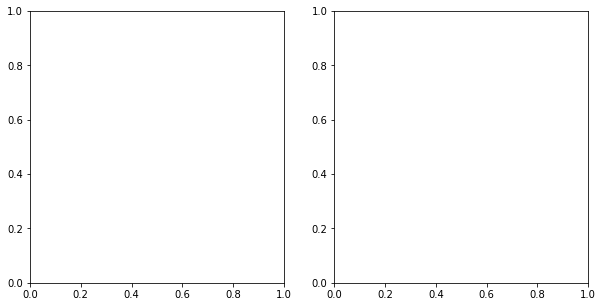

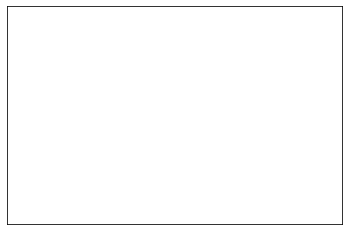

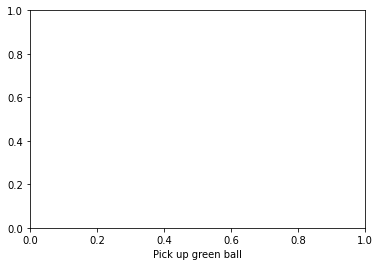

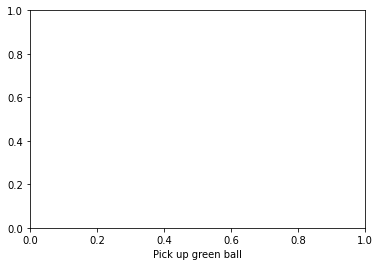

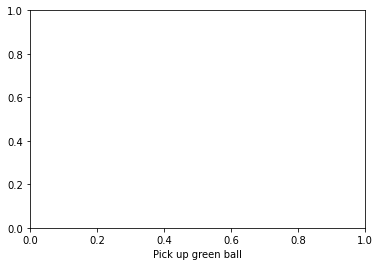

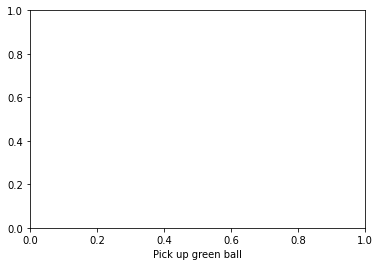

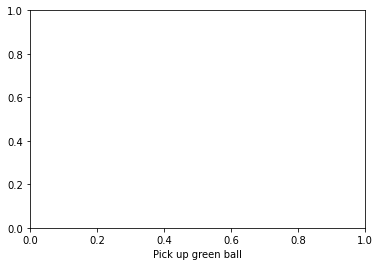

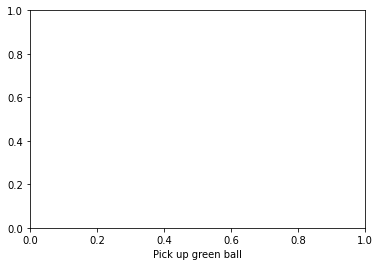

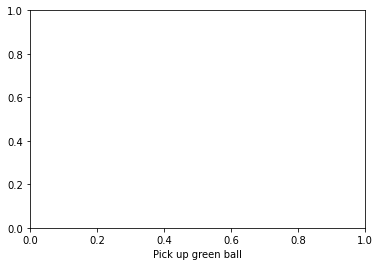

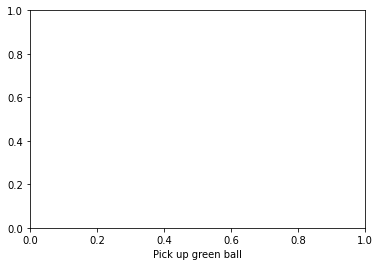

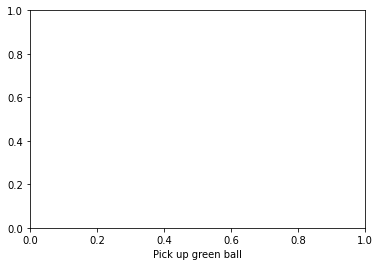

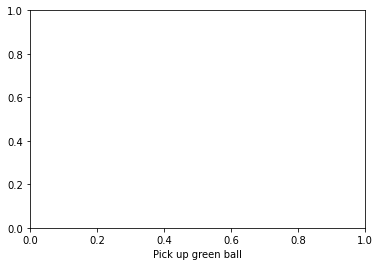

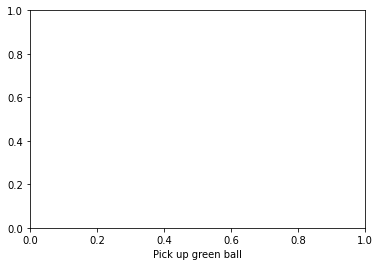

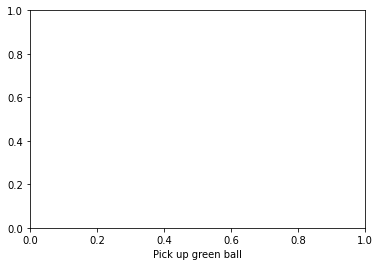

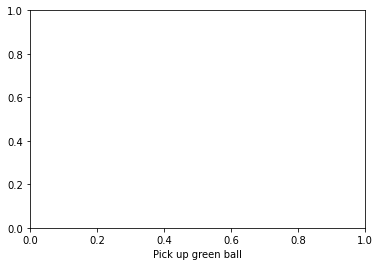

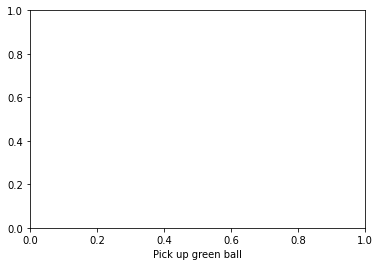

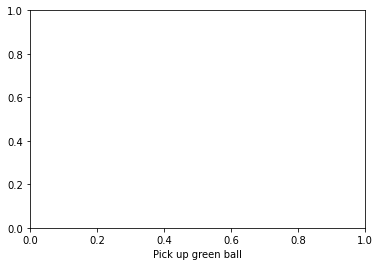

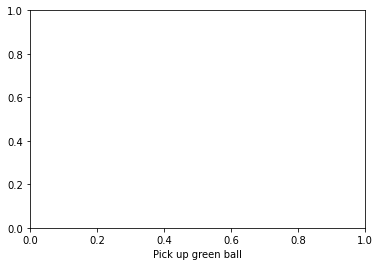

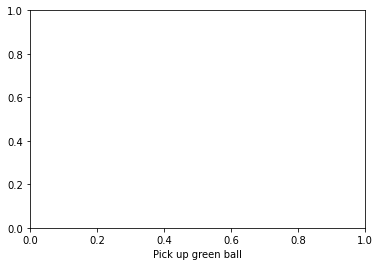

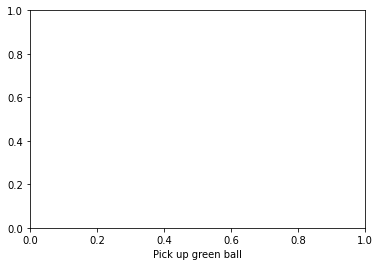

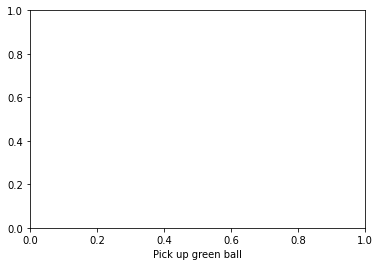

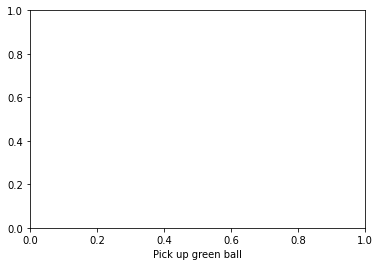

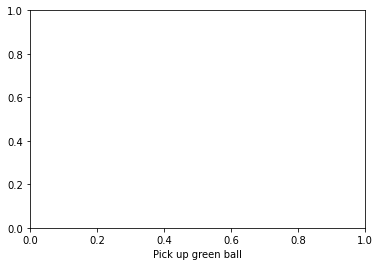

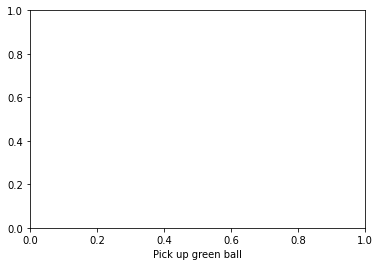

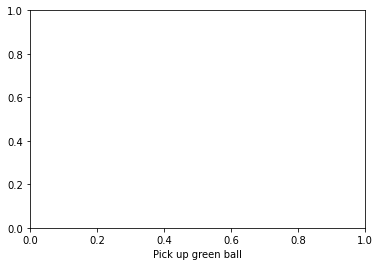

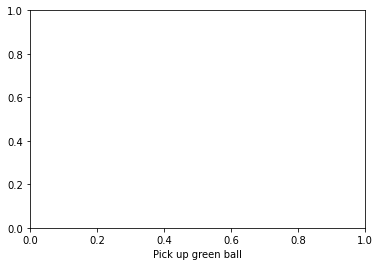

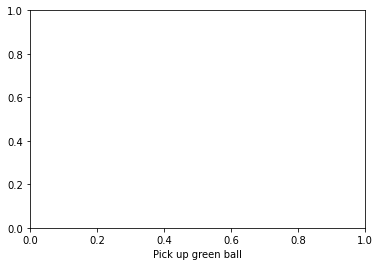

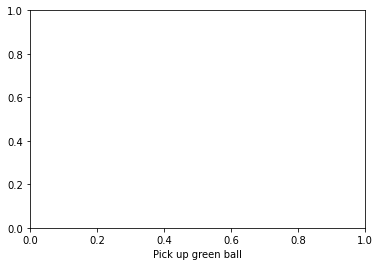

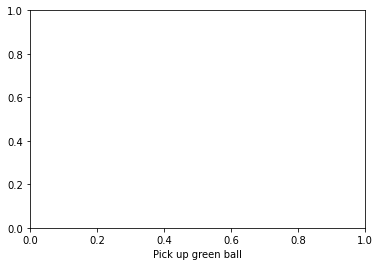

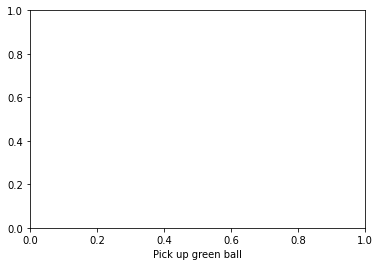

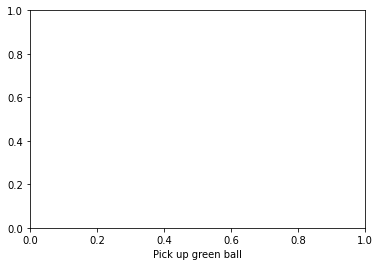

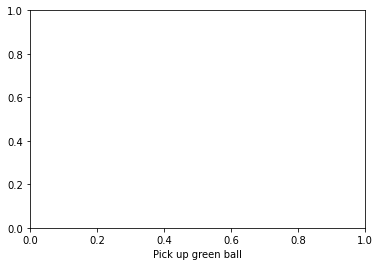

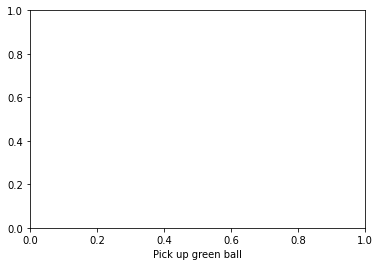

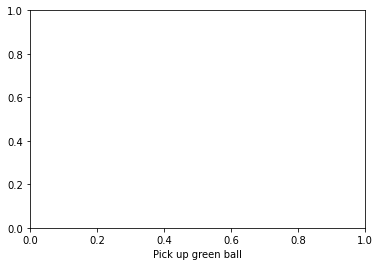

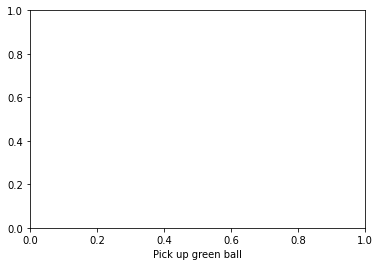

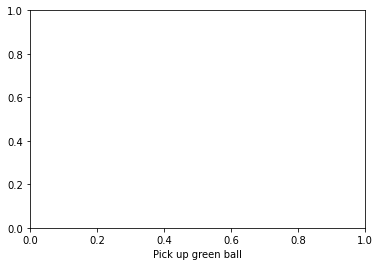

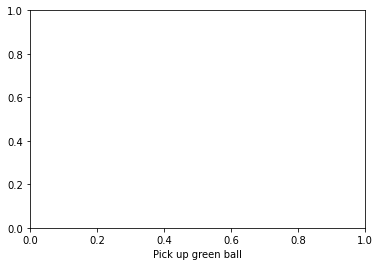

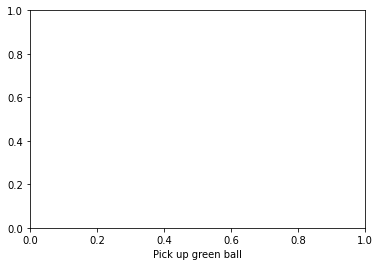

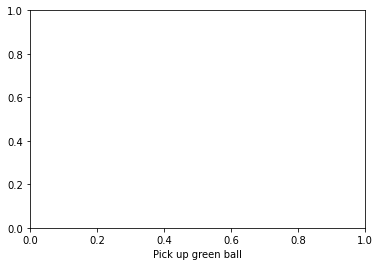

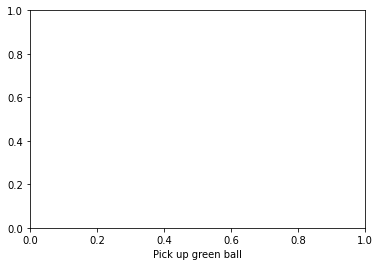

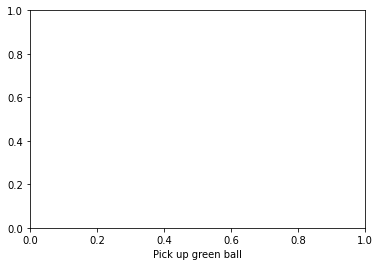

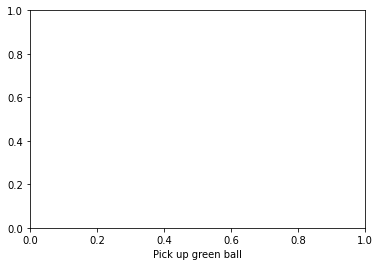

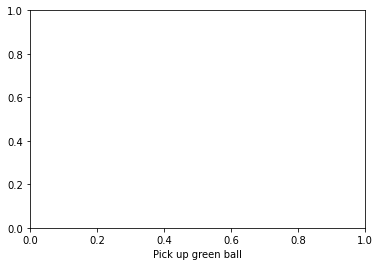

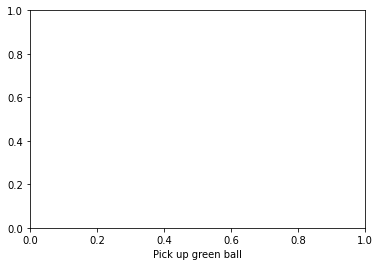

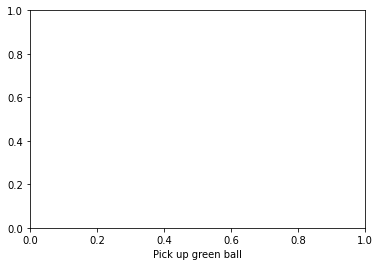

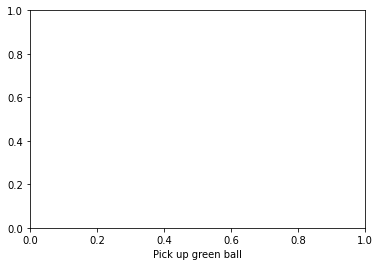

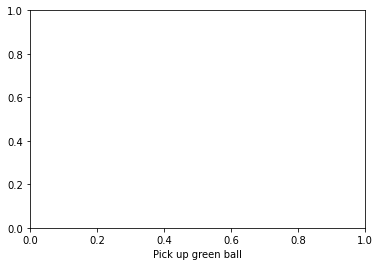

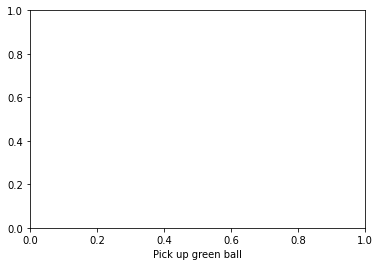

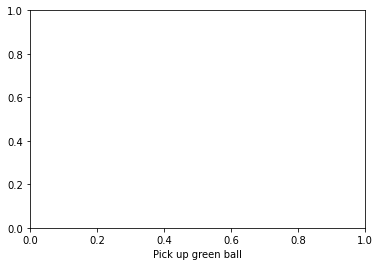

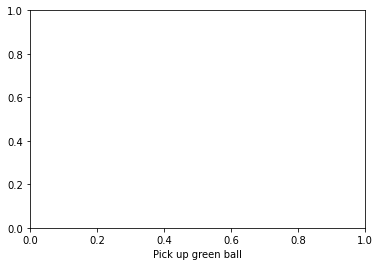

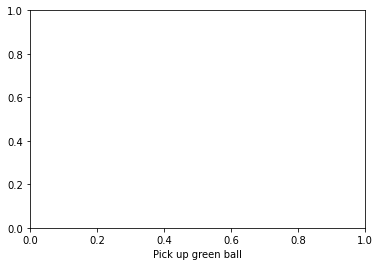

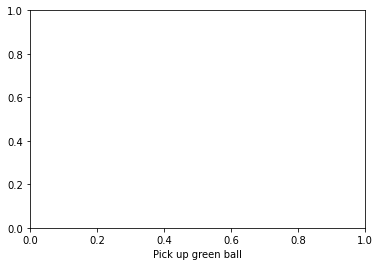

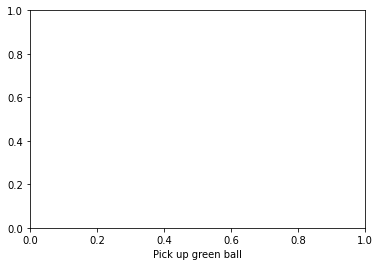

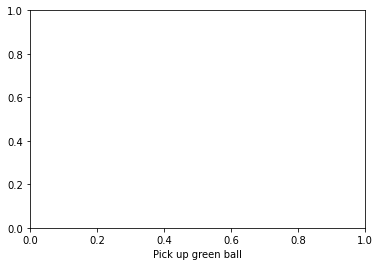

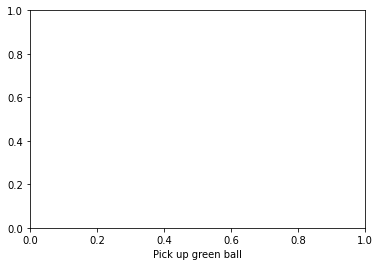

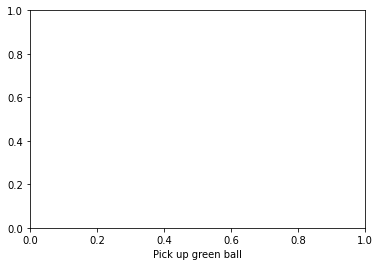

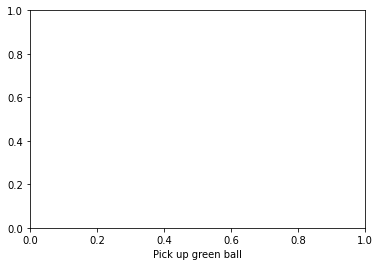

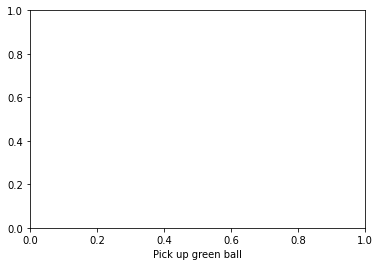

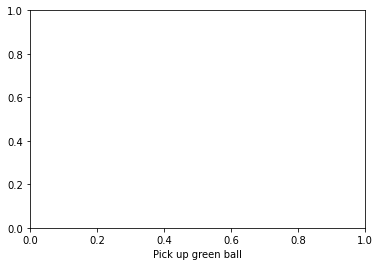

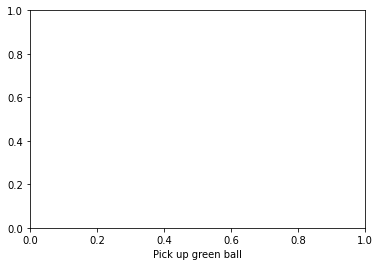

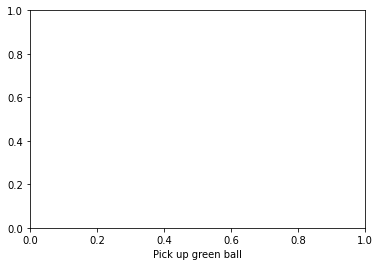

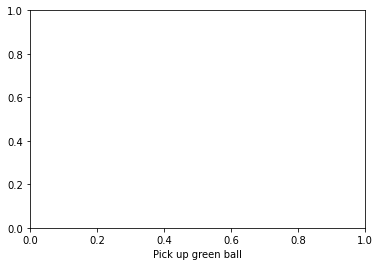

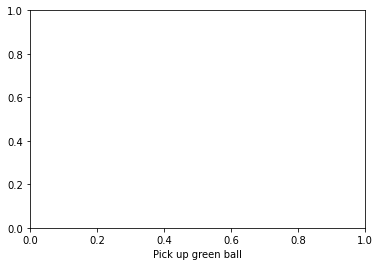

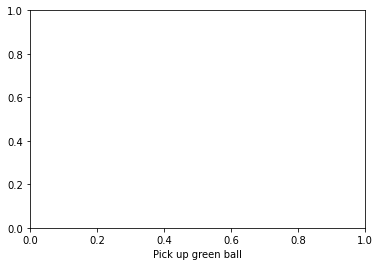

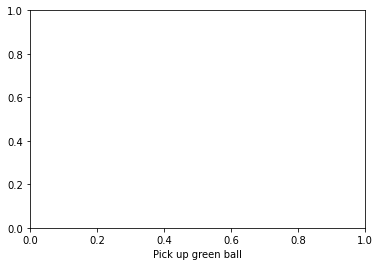

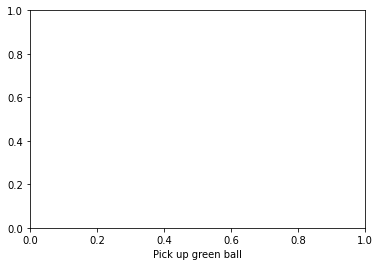

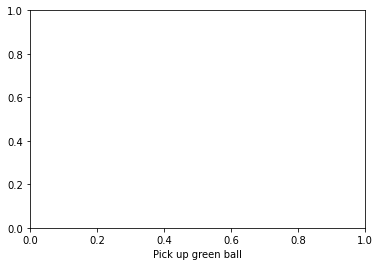

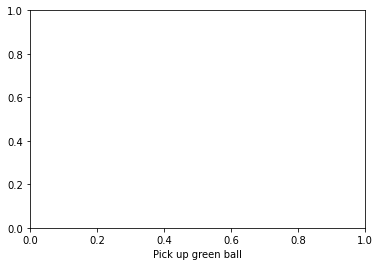

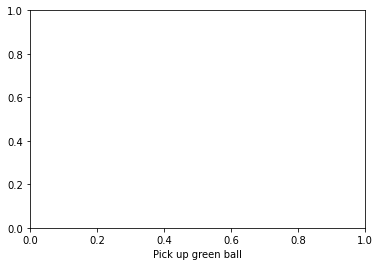

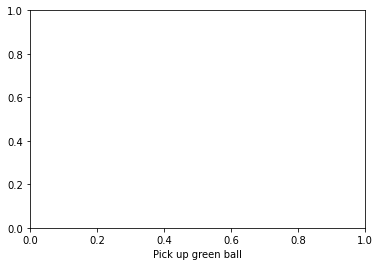

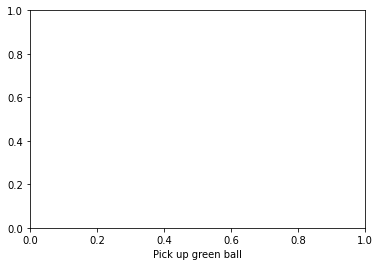

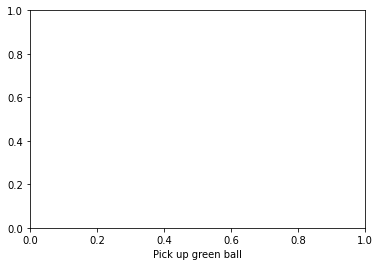

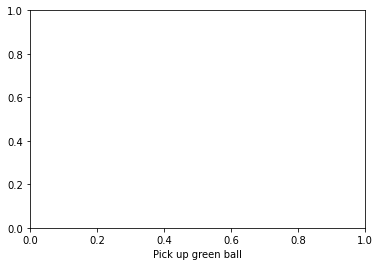

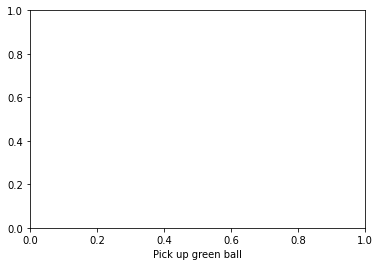

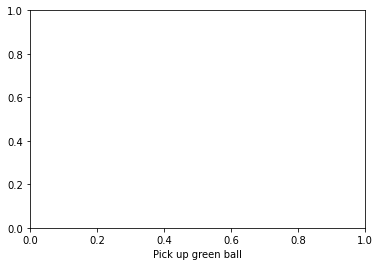

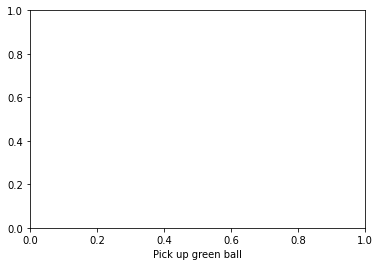

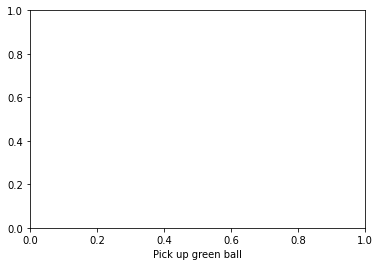

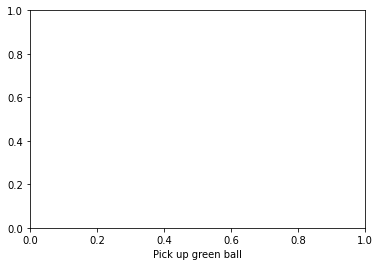

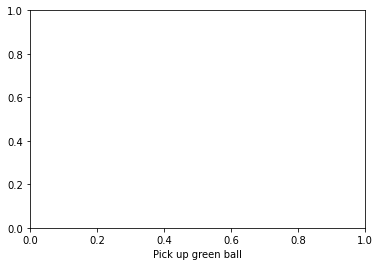

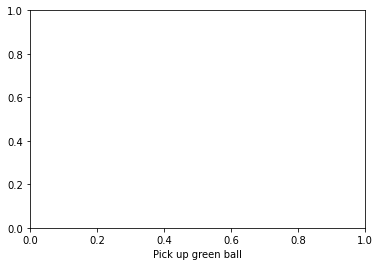

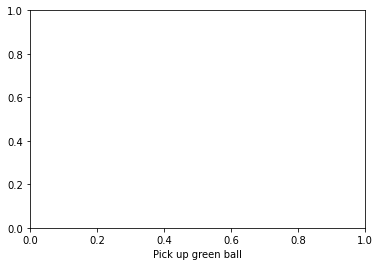

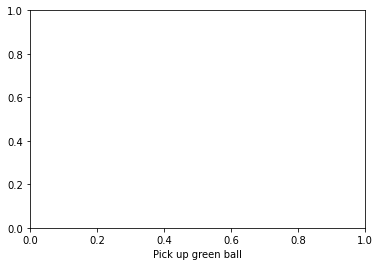

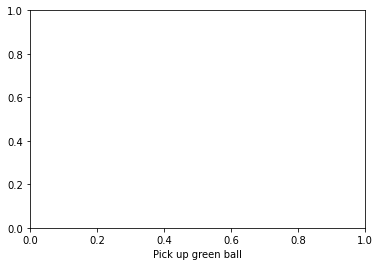

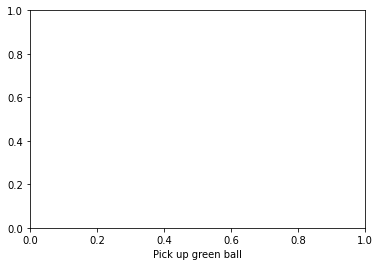

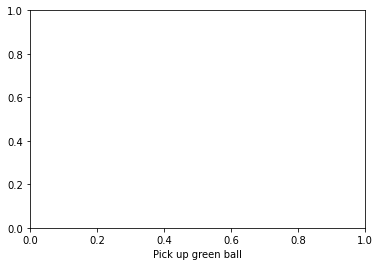

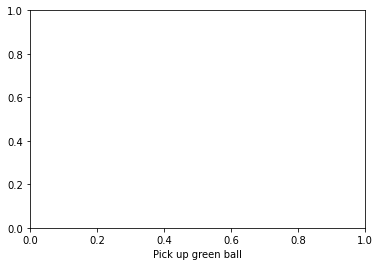

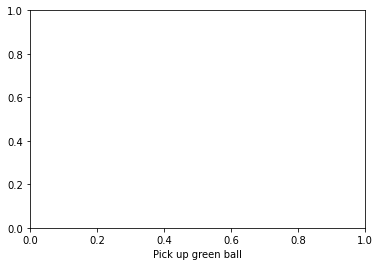

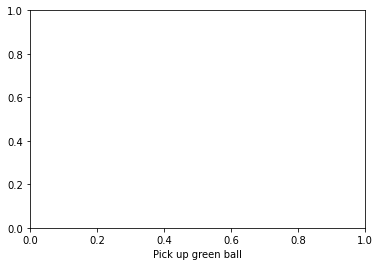

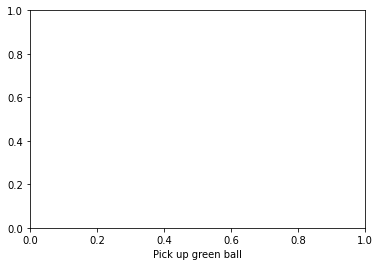

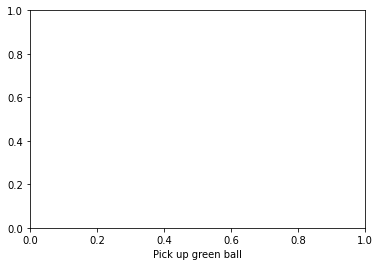

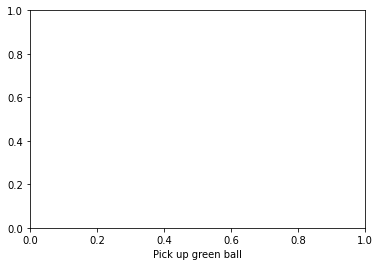

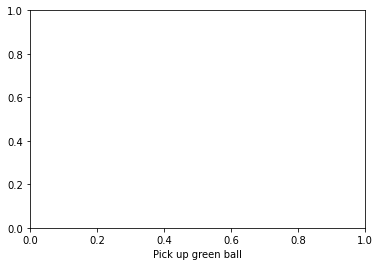

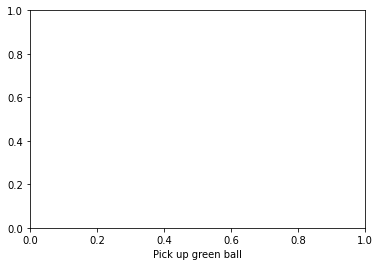

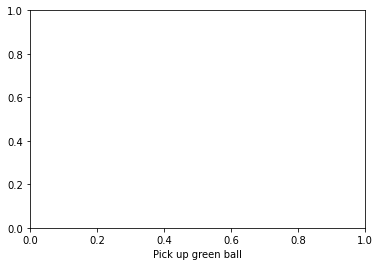

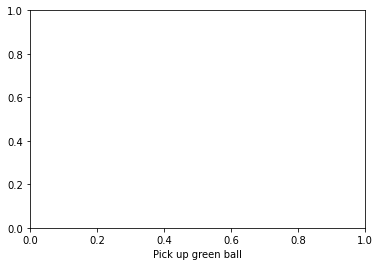

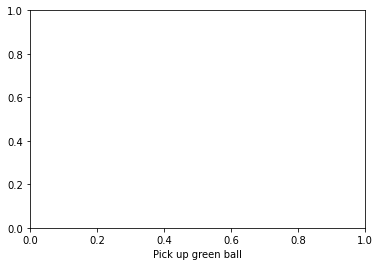

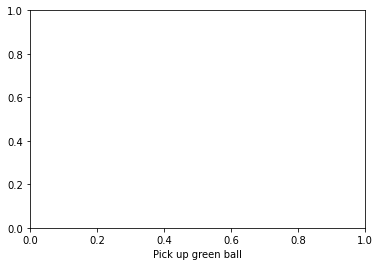

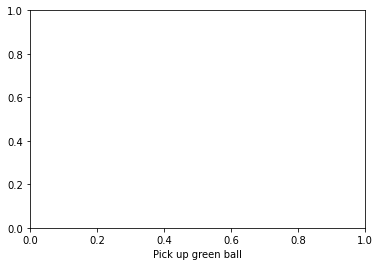

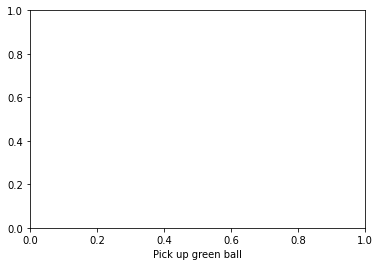

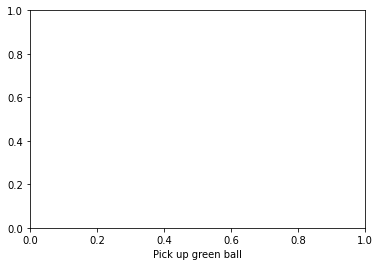

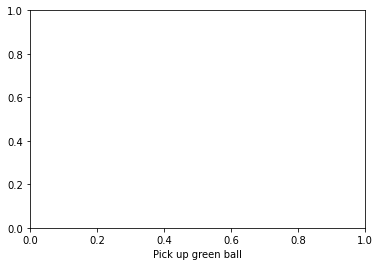

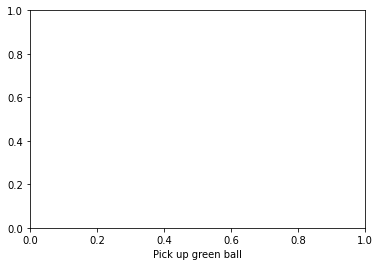

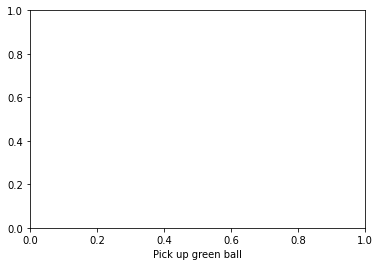

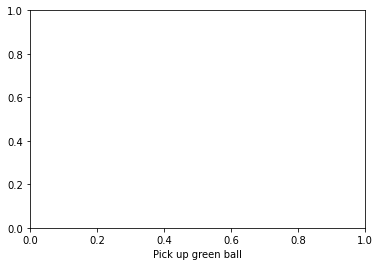

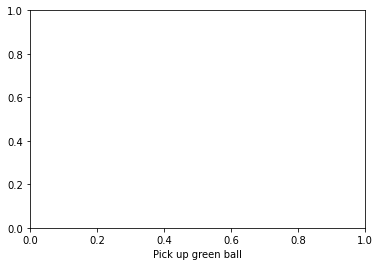

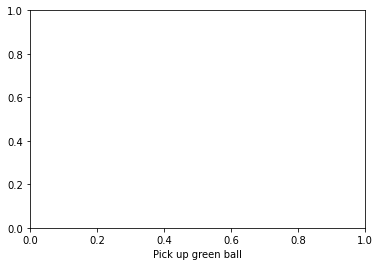

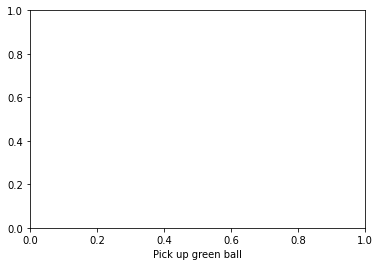

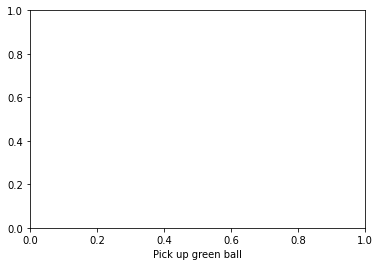

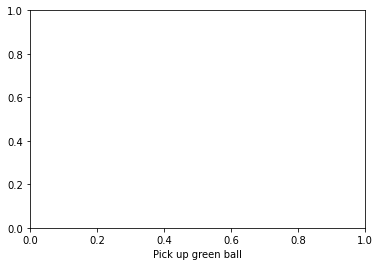

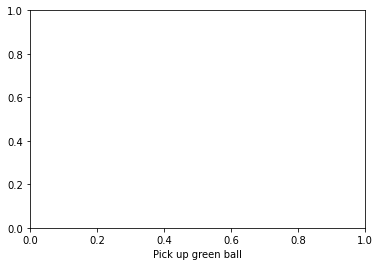

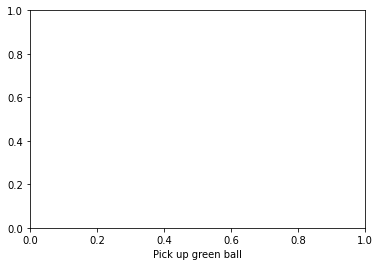

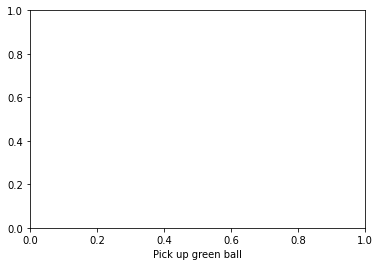

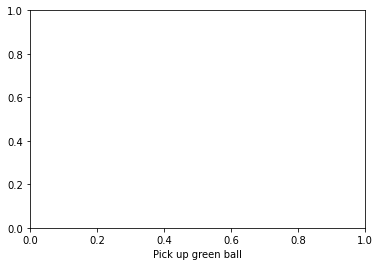

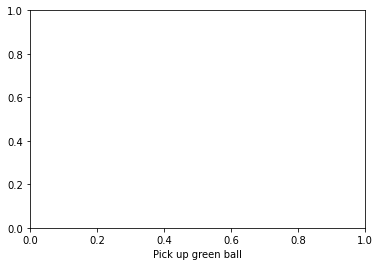

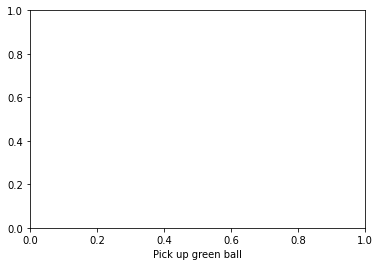

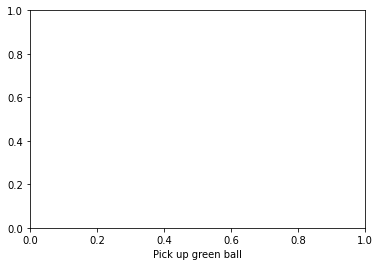

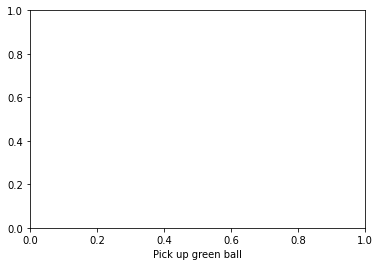

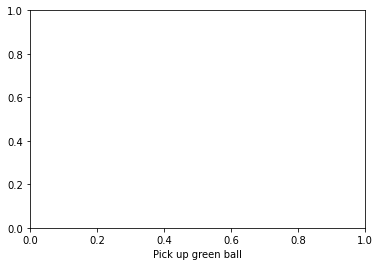

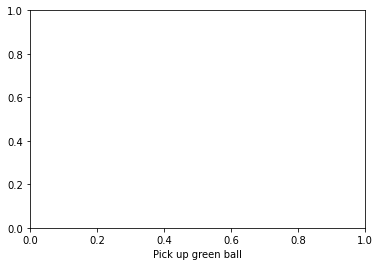

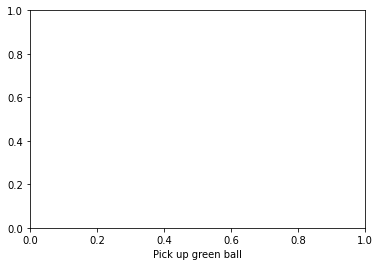

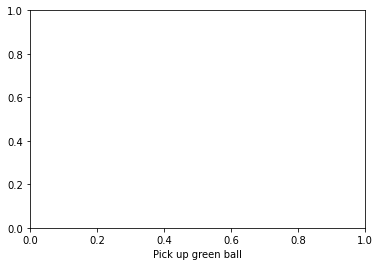

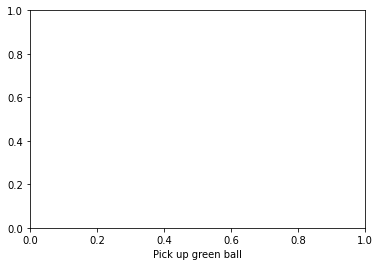

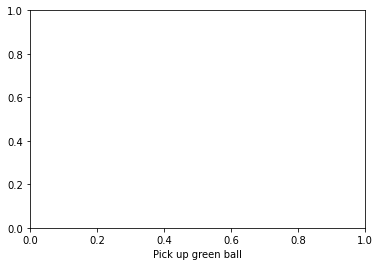

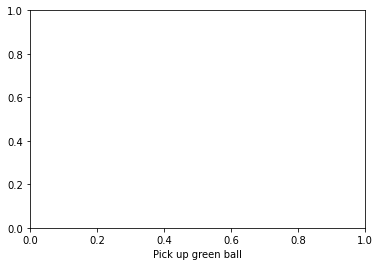

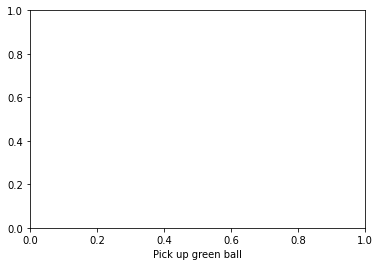

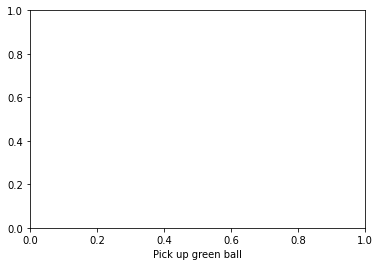

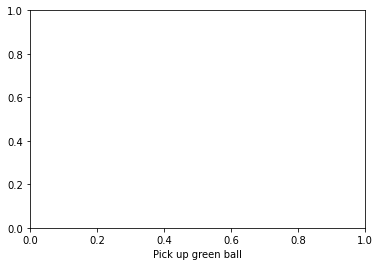

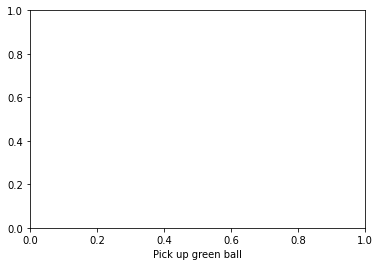

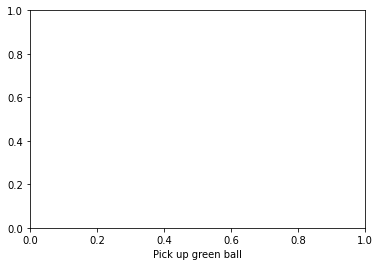

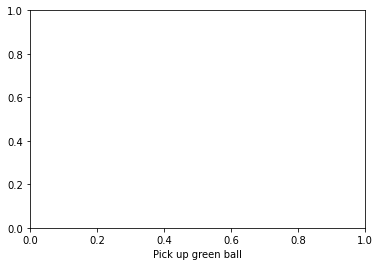

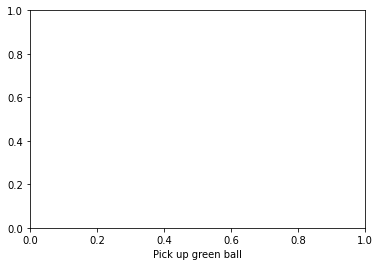

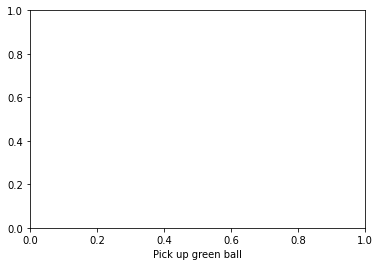

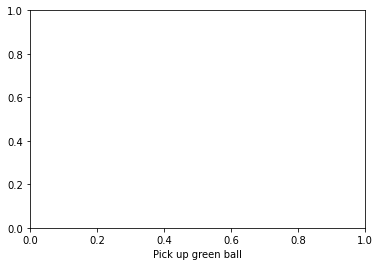

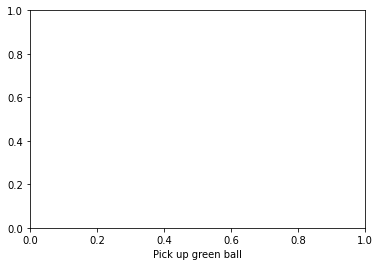

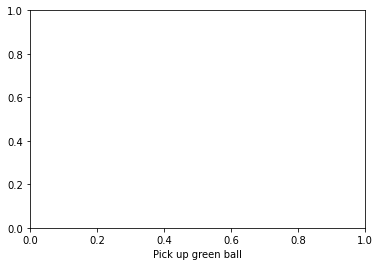

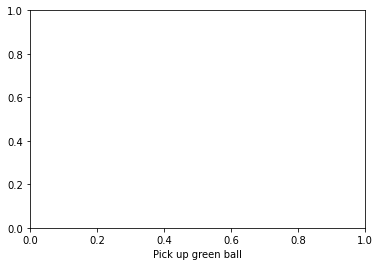

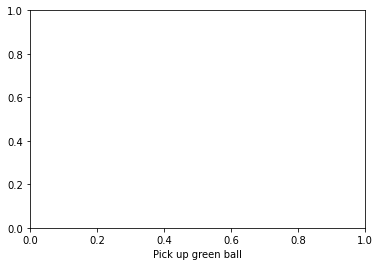

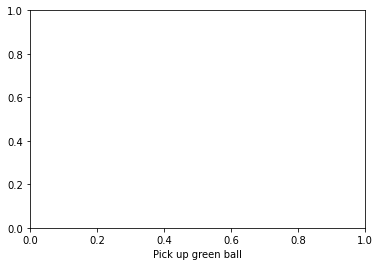

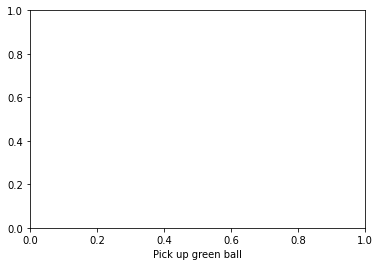

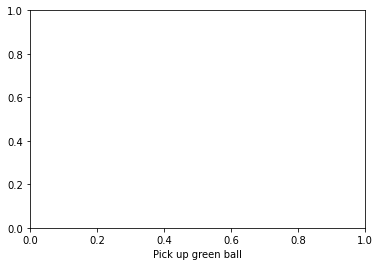

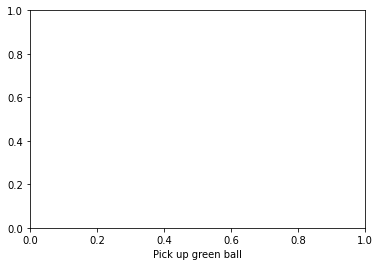

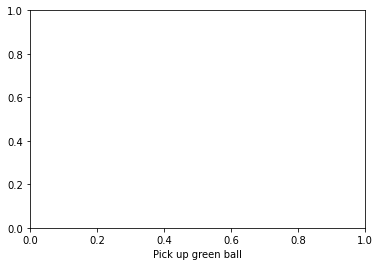

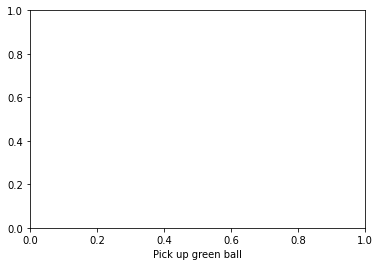

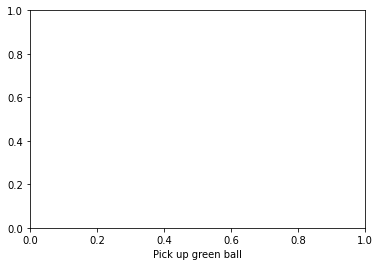

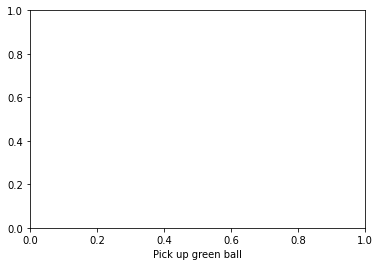

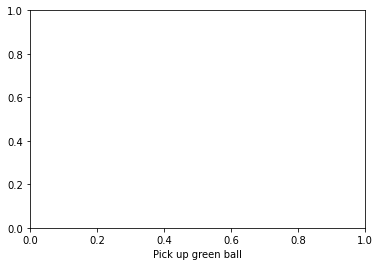

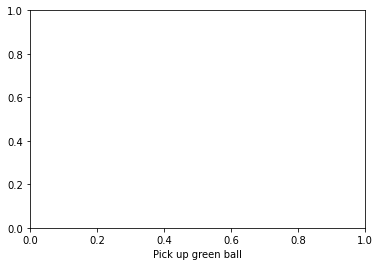

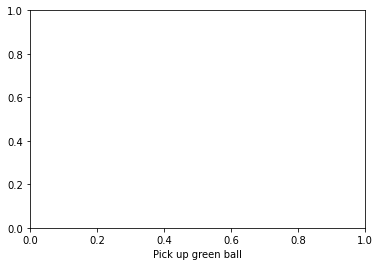

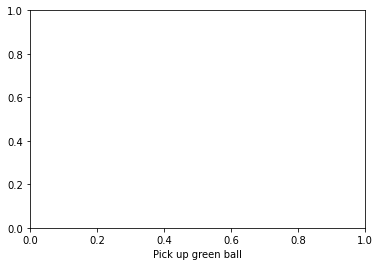

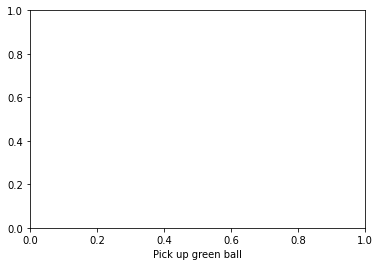

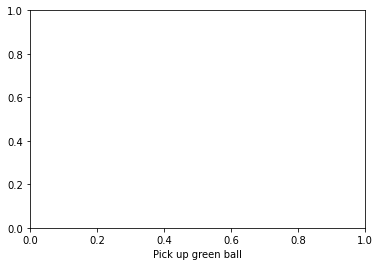

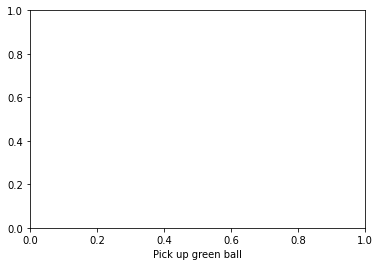

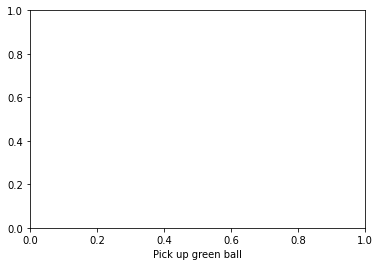

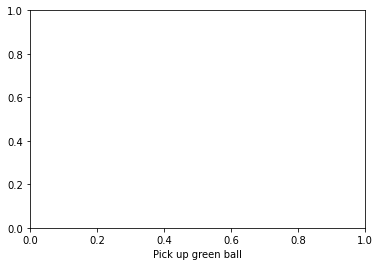

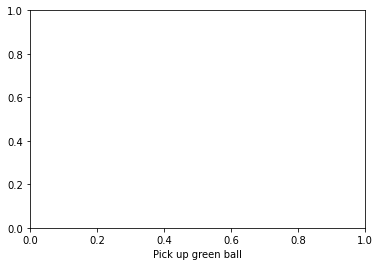

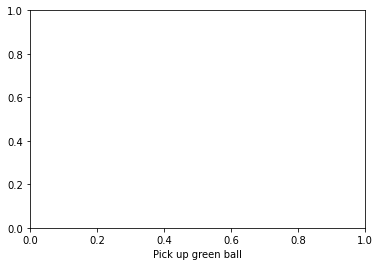

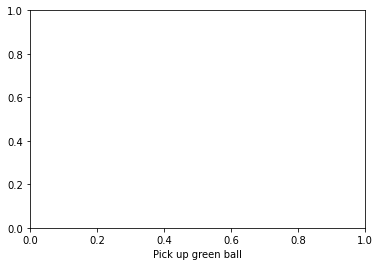

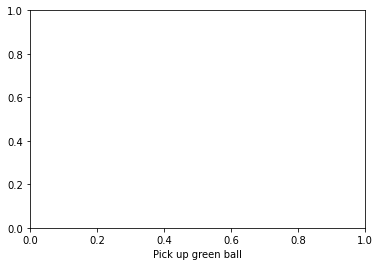

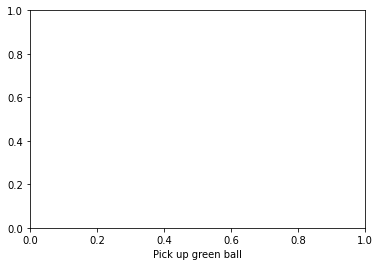

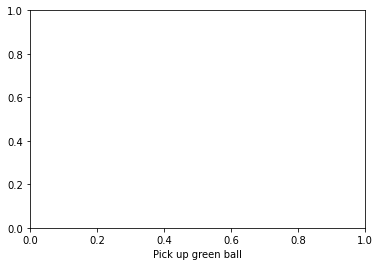

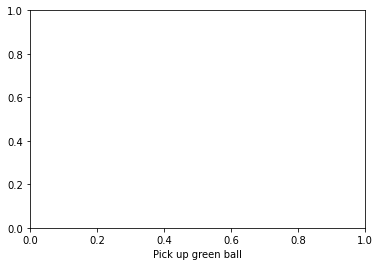

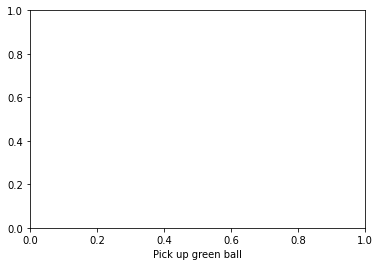

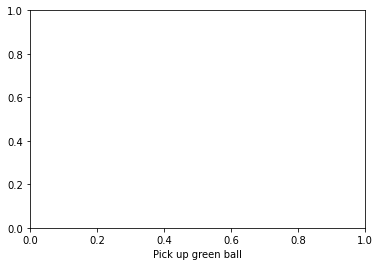

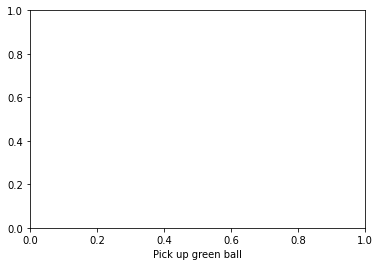

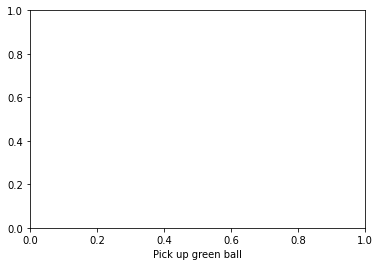

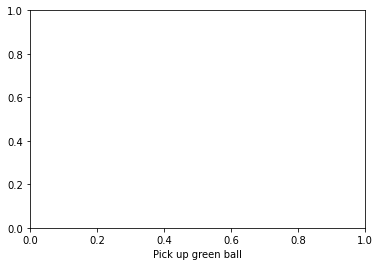

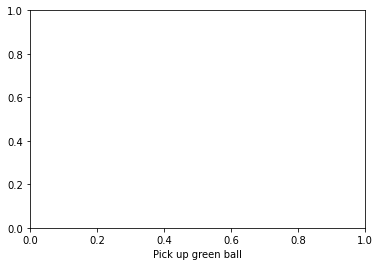

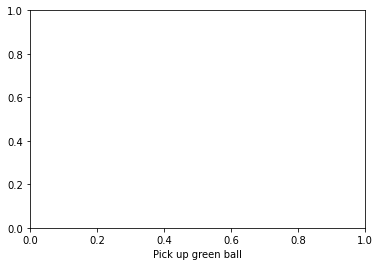

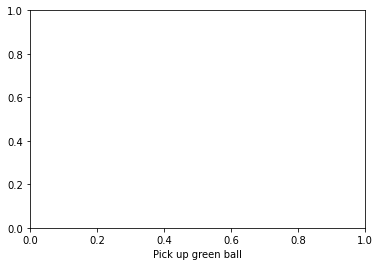

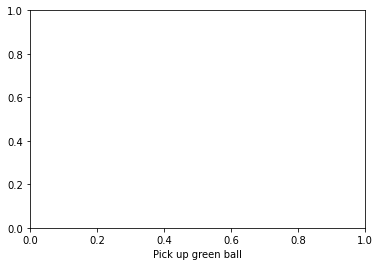

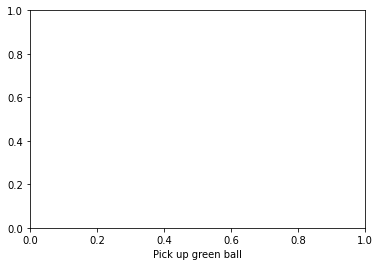

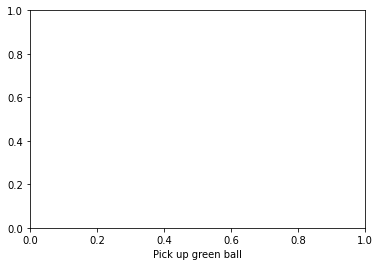

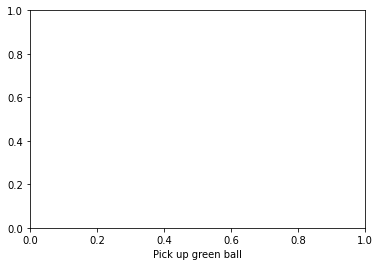

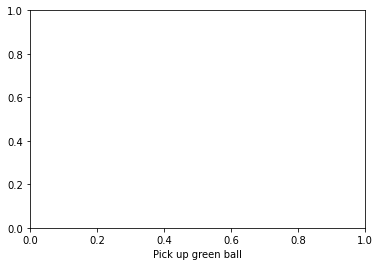

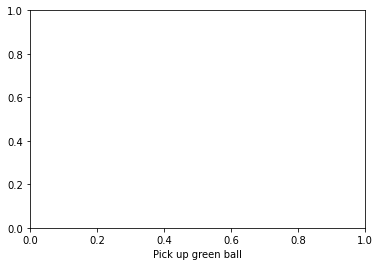

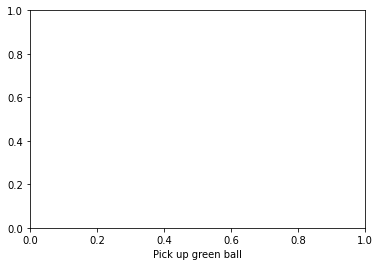

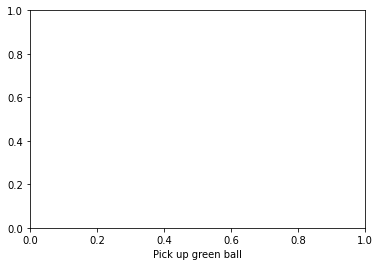

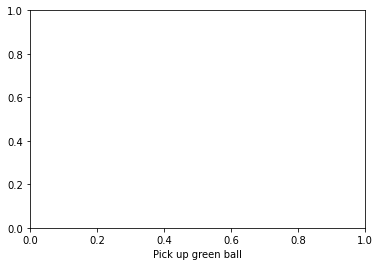

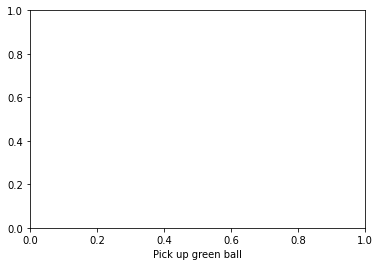

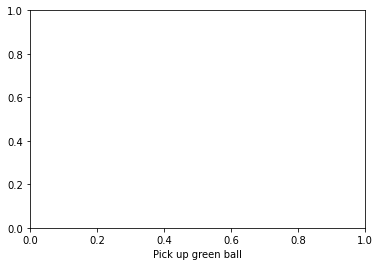

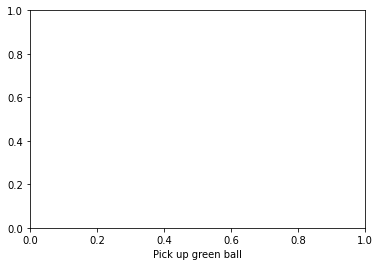

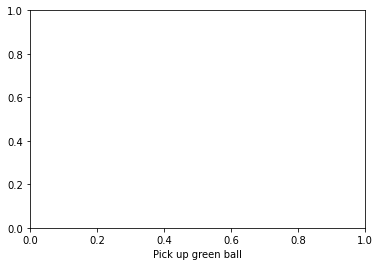

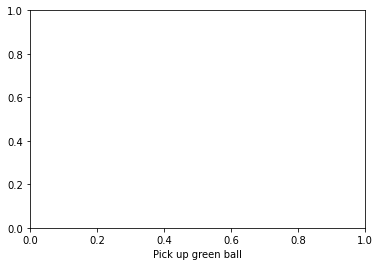

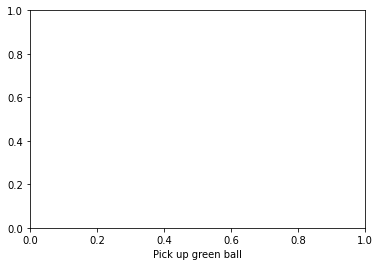

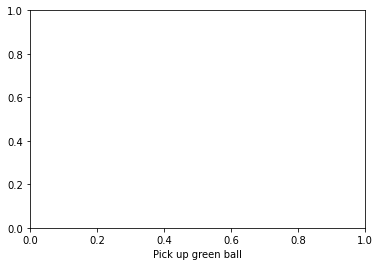

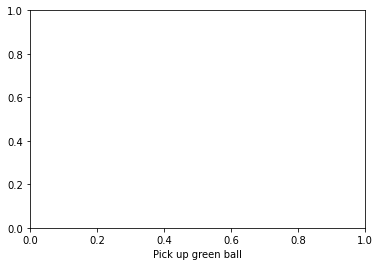

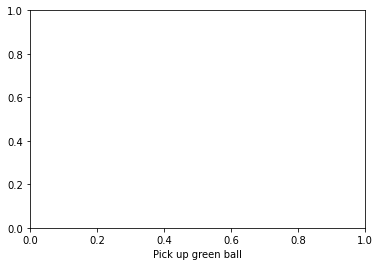

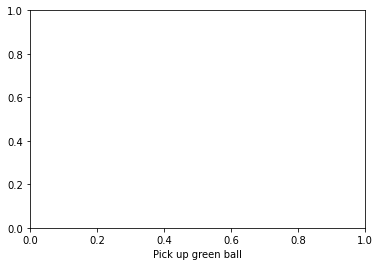

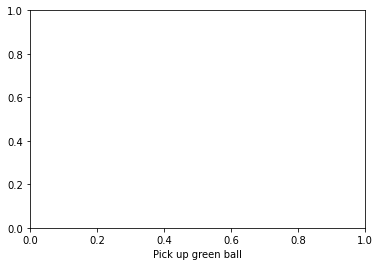

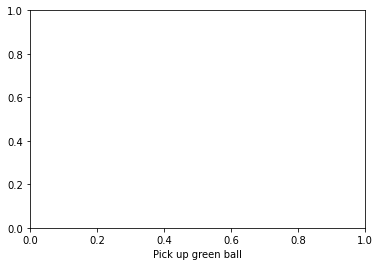

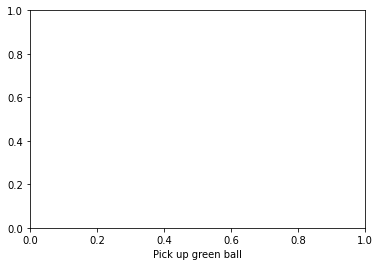

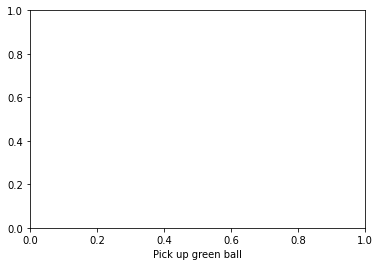

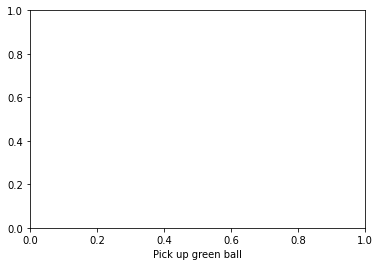

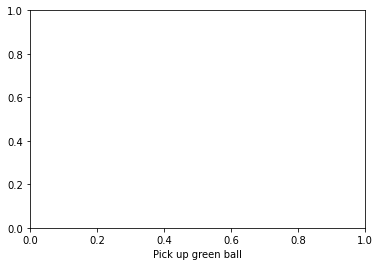

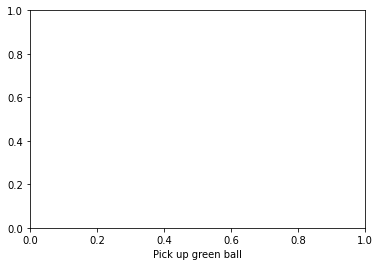

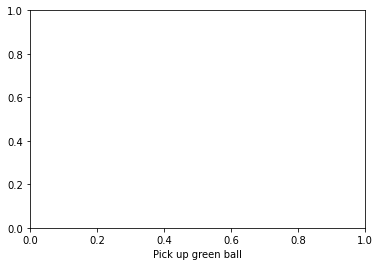

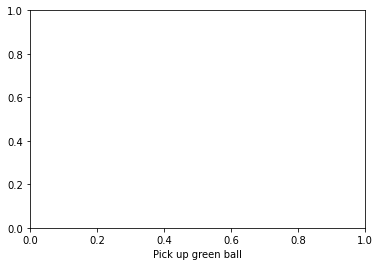

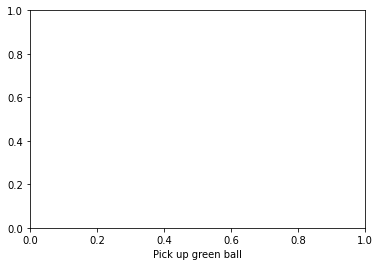

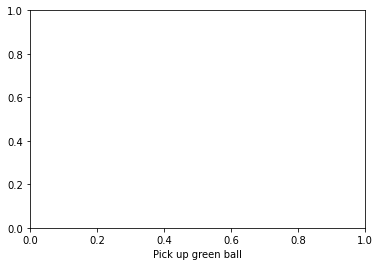

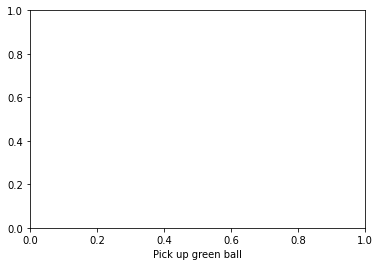

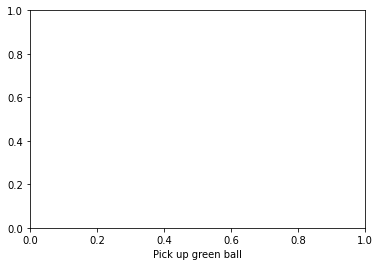

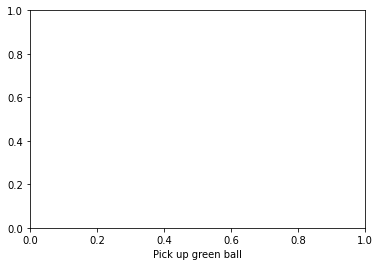

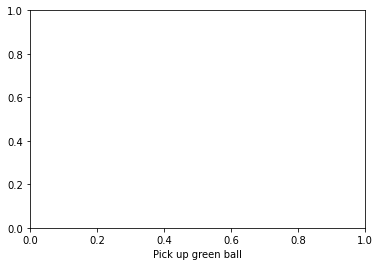

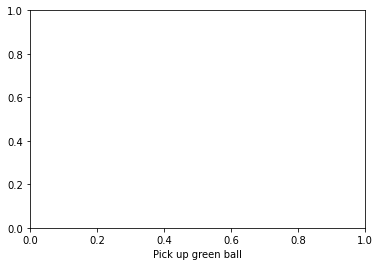

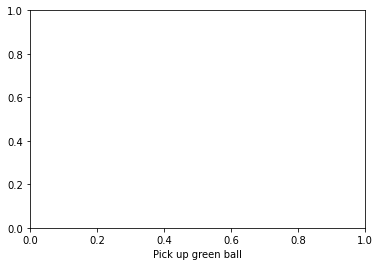

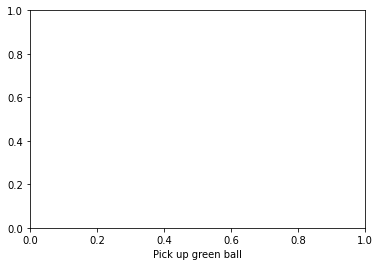

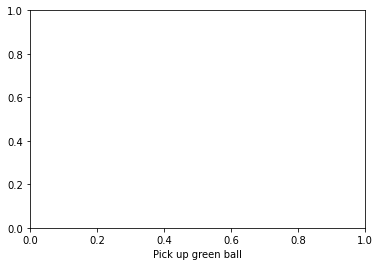

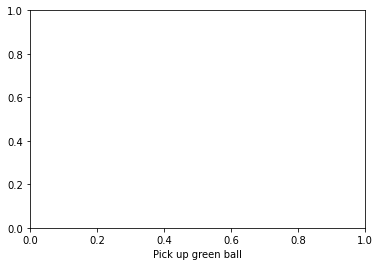

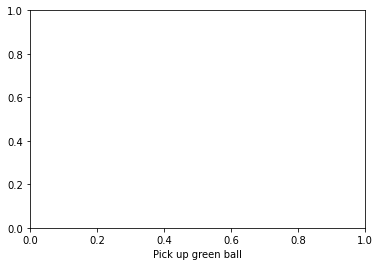

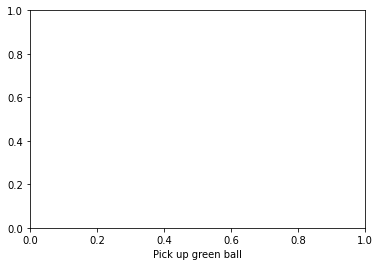

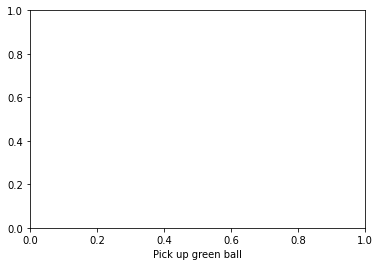

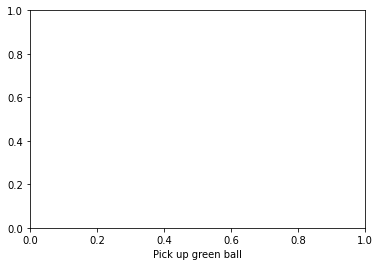

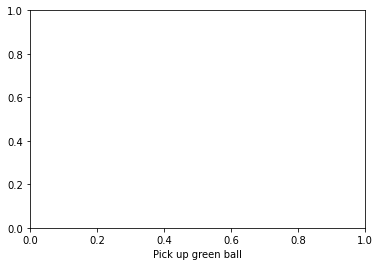

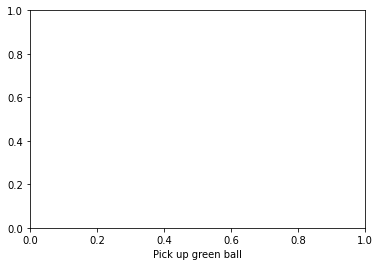

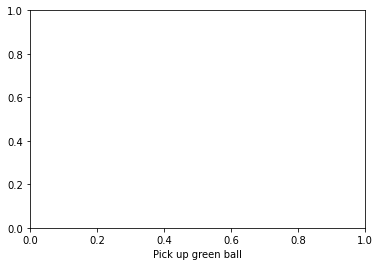

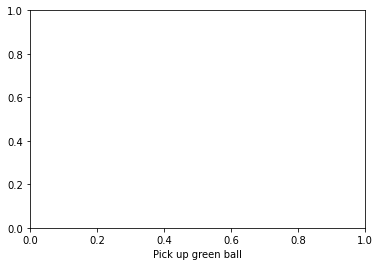

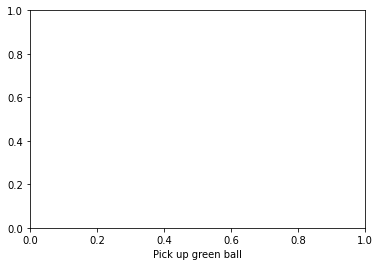

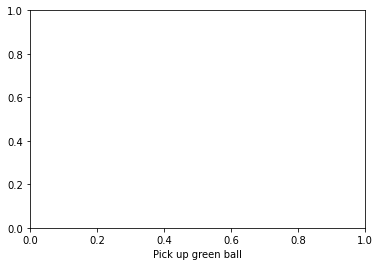

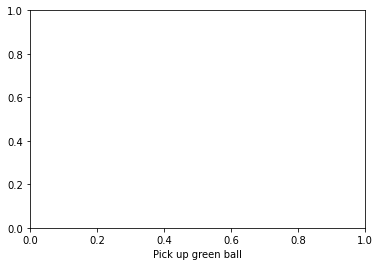

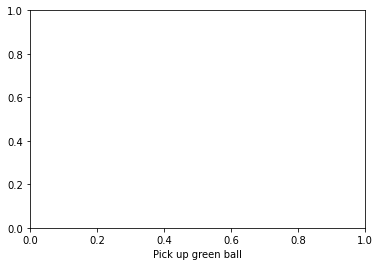

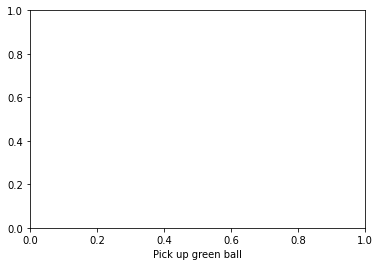

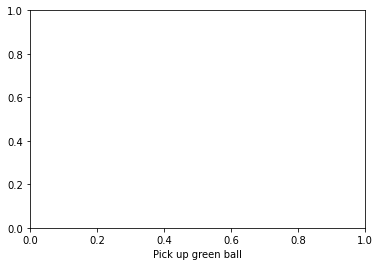

In [9]:
########### TESTING

#Experiment 3
trial_description = 'Validating second agent on new, second, environment, along with logging of the training'
trial_name = '2nd agent training and validation - flip left and right'
project_name = "learning-by-hacking"
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 5000,
    "env_name": "2nd environment",
    "ROOM_SIZE": 9,
    "BALL_COLOR": "green",
    "2ND_BALL_COLOR": "green",
    "TILE_SIZE": 8,
    "Trial description": trial_description}

train_2nd_agent_and_validate_test(trial_description, trial_name, config, modelName = "first_agent", randomColor = False, log_wb=False)

# Experiments

Sets up following experiments: 


1.   train_and_log_baseline - trains 1st agent and logs related data to W&B
2.   validate_baseline - validates 1st agent on the second environment. 
3.   train_2nd_agent_and_validate - trains second agent and validates it on second environment. 

Note: only experiments 2 and 3 are assumed to get changed with different environment changes. They also need the first agent to be provided for loading. 


## Experiment definitions

In [9]:
def validate_baseline(trial_description, trial_name, config, modelName = "first_agent", randomColor = False):
  ### Initiate W&B connection
  project_name = "learning-by-hacking"
  run = wandb.init(
    project=project_name,
    entity="learning-by-hacking",
    name = trial_name,
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
  )

  ### Load agent
  first_agent = PPO.load(modelName, custom_objects=custom_objects)
  print("loaded:", "gamma =", first_agent.gamma, "n_steps =", first_agent.n_steps)

  ############################################################################################################## 
  # Only this section is expected to get changed per different experiments

  ### choose random color or not
  second_env_kwargs = {"size": config["ROOM_SIZE"], "ball_color": config["2ND_BALL_COLOR"], "tile_size": config["TILE_SIZE"]} 
  second_env = ObsLeftRightSwitchWrapper(**second_env_kwargs)

  ############################################################################################################## 
  
  ### Validate
  n_val_episodes = 1000
  mean_reward, std_reward = evaluate_policy(first_agent, second_env, n_eval_episodes=n_val_episodes)
  
  wandb.log({'val_mean_reward': mean_reward, 'val_std_reward': std_reward}) #log mean reward
  save_gif3("First agent on second environment", 100, 10, first_agent, second_env, log_to_wb = False) #log gif to W&B

  wandb.finish() 


In [10]:
def train_2nd_agent_and_validate(trial_description, trial_name, config, modelName = "first_agent", randomColor = False, log_wb=False):
  ### Initiate W&B connection
  project_name = "learning-by-hacking"
  if log_wb:
    run = wandb.init(
      project=project_name,
      entity="learning-by-hacking",
      name = trial_name,
      config=config,
      sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
      monitor_gym=True,  # auto-upload the videos of agents playing the game
      save_code=True,  # optional
    )

  ### Load agent
  first_agent = PPO.load(modelName, custom_objects=custom_objects)
  print("loaded:", "gamma =", first_agent.gamma, "n_steps =", first_agent.n_steps)

  ############################################################################################################## 
  # Only this section is expected to get changed per different experiments

  ### choose random color or not
  second_env_kwargs = {"size": config["ROOM_SIZE"], "ball_color": config["2ND_BALL_COLOR"], "tile_size": config["TILE_SIZE"]} 
  second_env =ObsLeftRightSwitchWrapper(**second_env_kwargs)
  
  ## vectorize for training
  second_env_vector = make_vec_env(
    HackedLREnvironment,
    n_envs=1,                           # max 2 for colaboratory
    vec_env_cls=SubprocVecEnv,
    env_kwargs={"env": second_env, 
                "first_agent": first_agent},
    monitor_dir="env_monitor")
  
  ### train second agent
  policy_kwargs = dict(activation_fn=nn.ReLU)
  second_agent = PPO(
      config["policy_type"], 
      second_env_vector,
      gamma=0.85,
      policy_kwargs=policy_kwargs,
      verbose=1,
      tensorboard_log="second_agent_tb",
      ent_coef = 0
  )
  if log_wb:      
    second_agent.learn(total_timesteps=config["total_timesteps"], callback=WandbCallback( #callback for W&B
          model_save_path=f"models/{run.id}", verbose=2, ),
          )
  else: 
    second_agent.learn(total_timesteps=config["total_timesteps"])
  second_agent.save("second_agent")

  ############################################################################################################## 
  
  ### Validate
  env = HackedLREnvironment(second_env, first_agent)
  n_val_episodes = 1000
  mean_reward, std_reward = evaluate_policy(second_agent, env, n_eval_episodes=n_val_episodes)
  if log_wb:
    wandb.log({'val_mean_reward': mean_reward, 'val_std_reward': std_reward}) #log mean reward
  save_gif2("Second agent on second environment", 100, 10, second_agent, env, log_to_wb = log_wb) #log gif to W&B

  wandb.finish() 


## Running the experiments

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


loaded: gamma = 0.99 n_steps = 2048


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


val_mean_reward,▁
val_std_reward,▁
val_mean_reward,0.07445
val_std_reward,0.26147


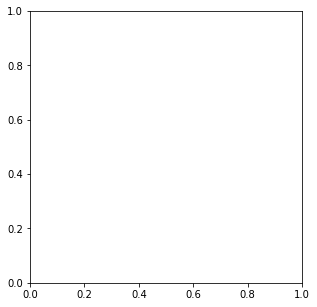

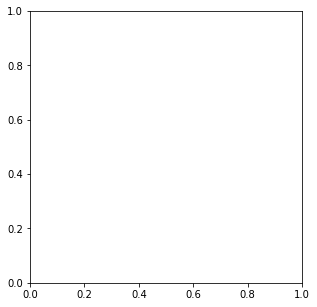

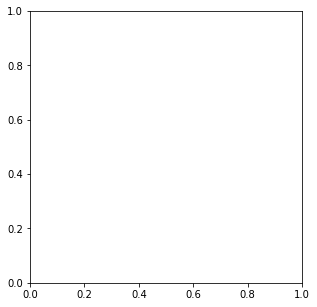

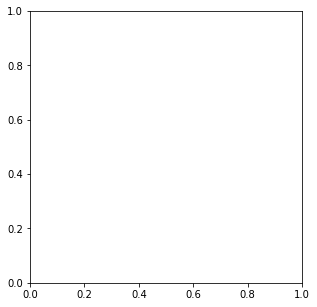

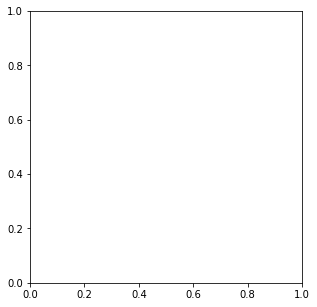

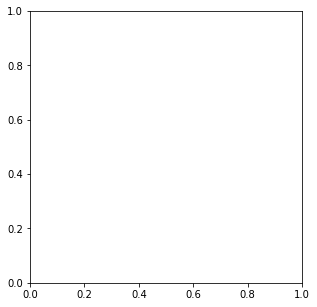

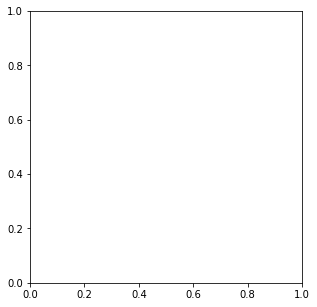

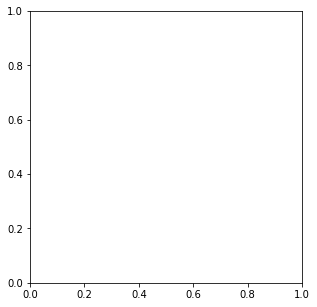

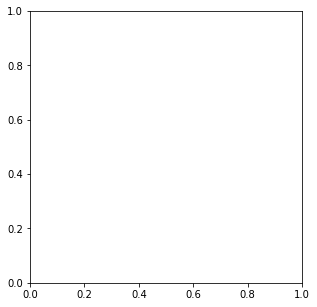

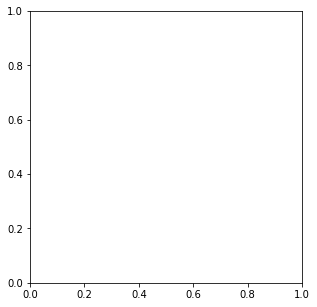

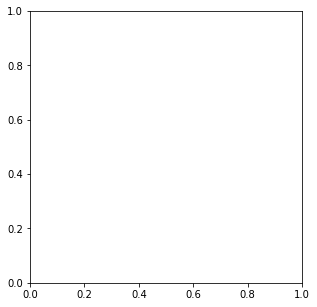

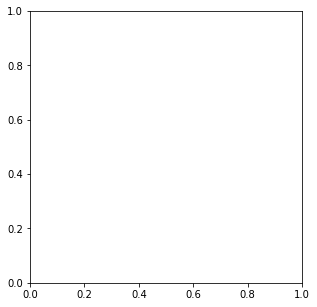

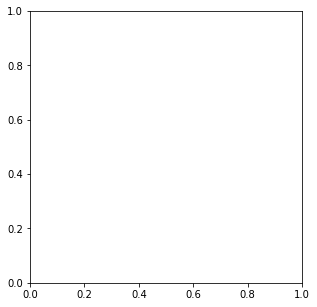

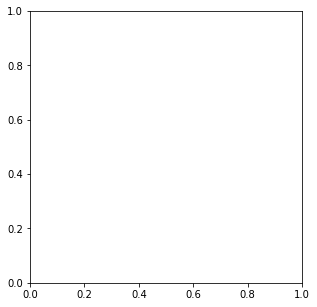

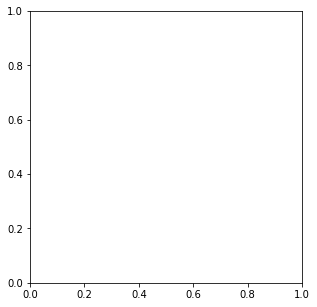

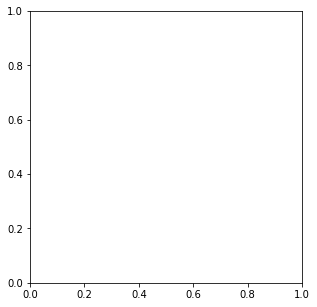

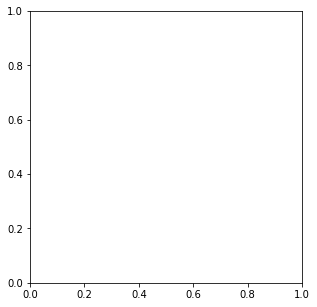

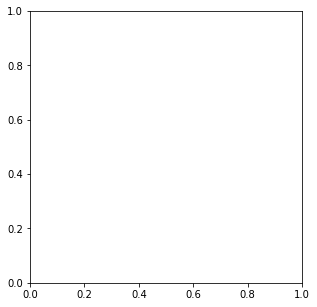

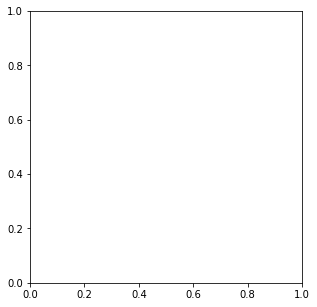

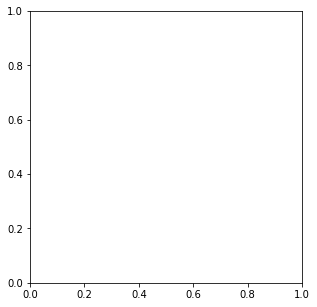

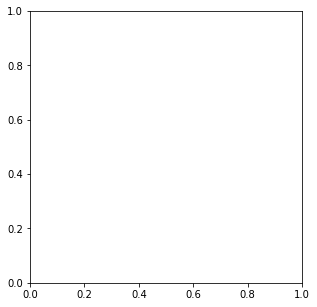

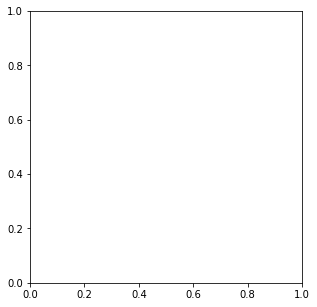

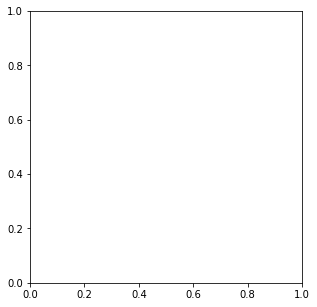

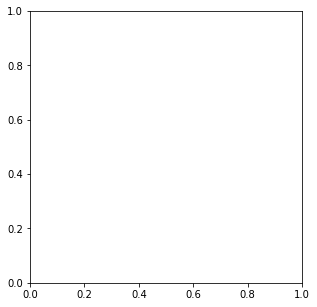

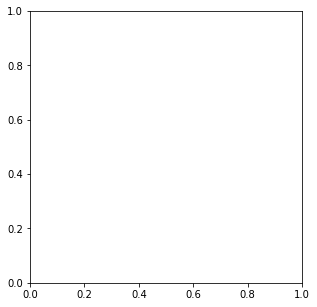

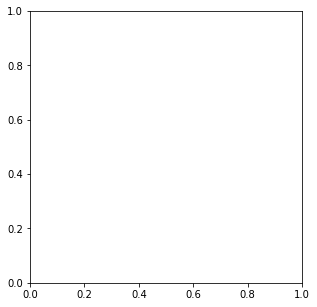

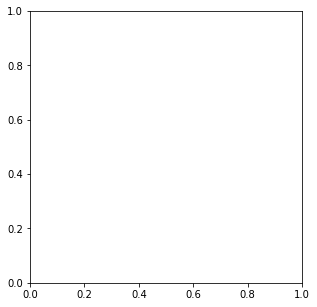

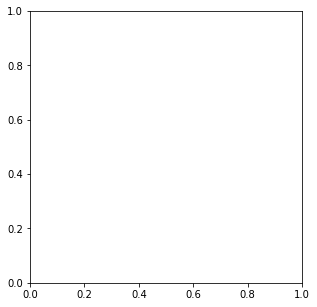

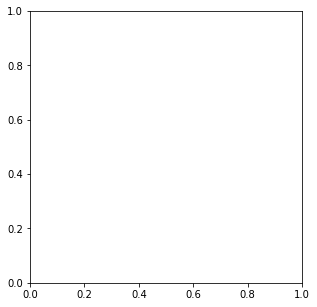

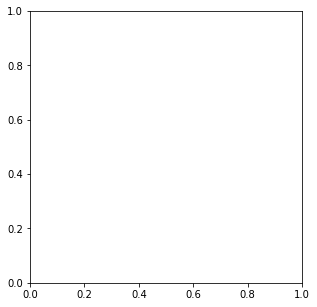

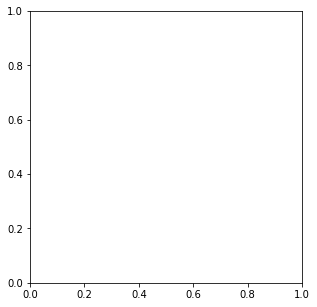

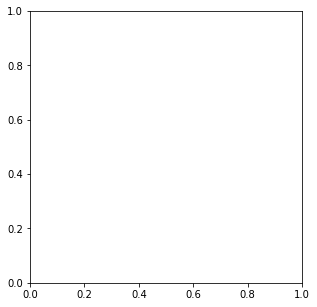

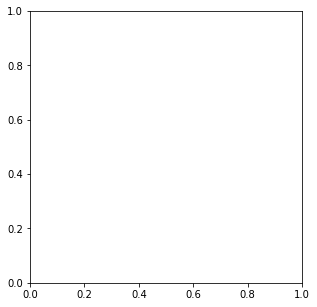

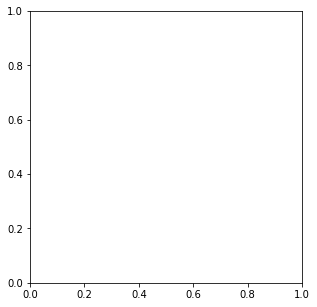

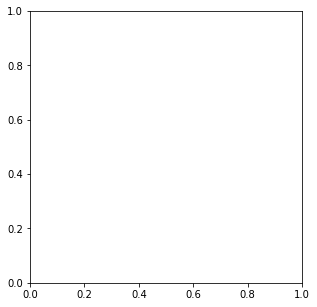

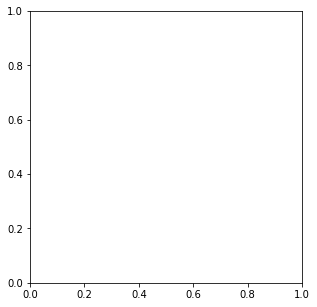

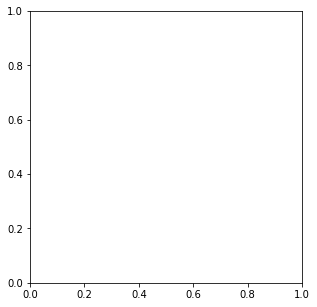

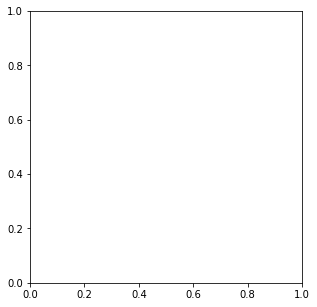

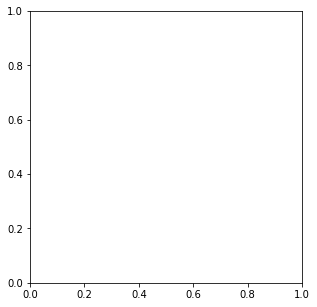

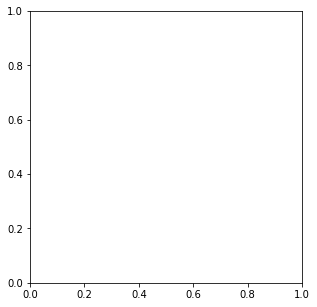

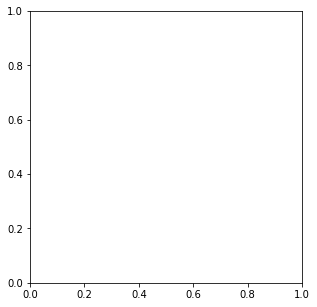

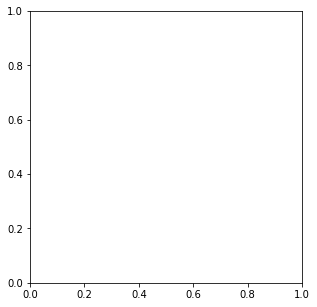

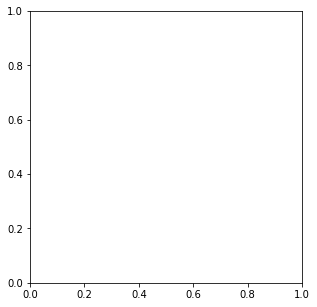

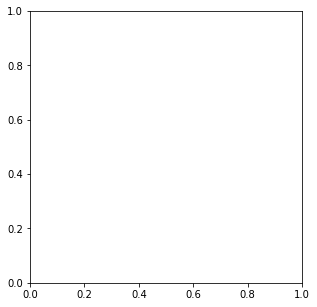

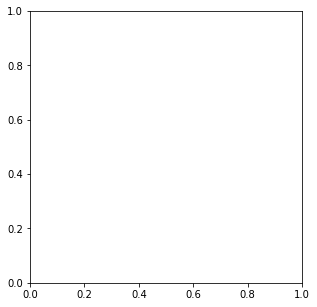

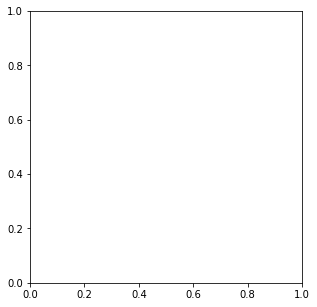

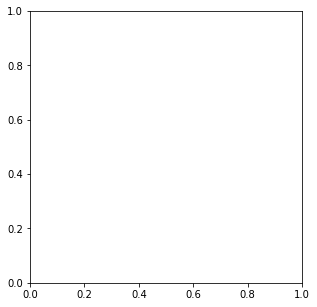

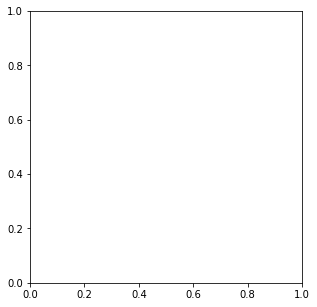

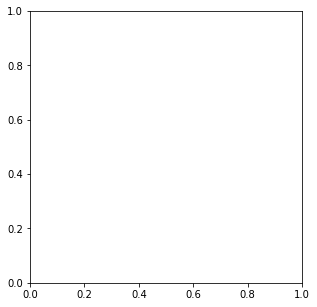

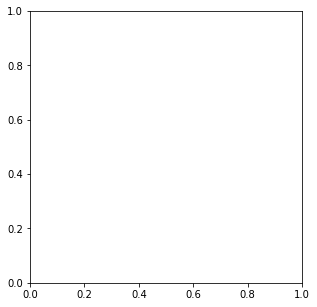

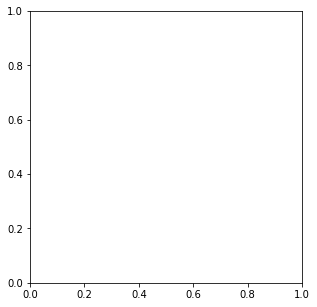

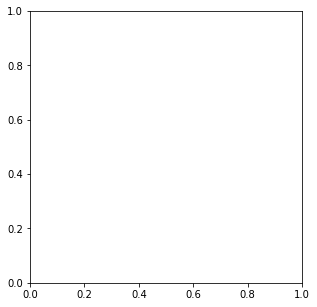

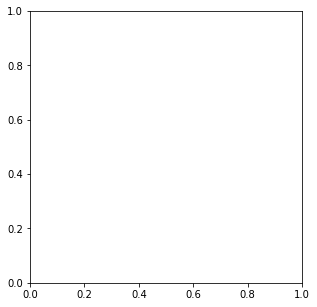

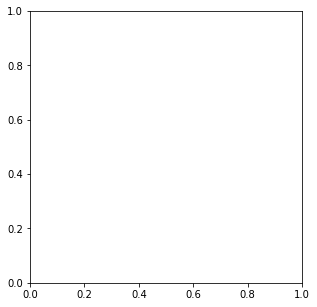

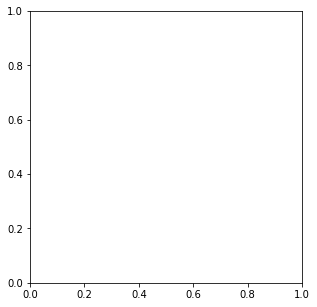

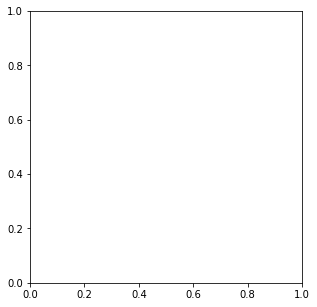

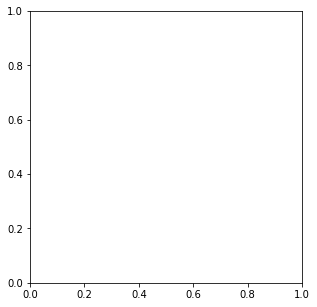

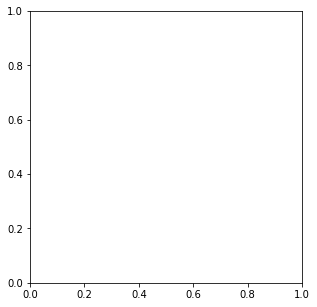

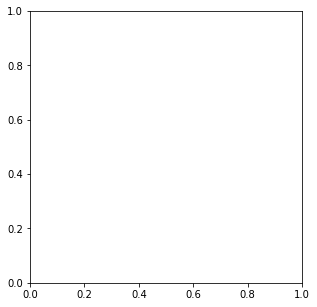

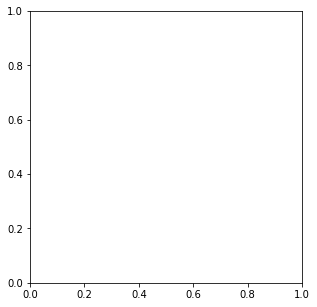

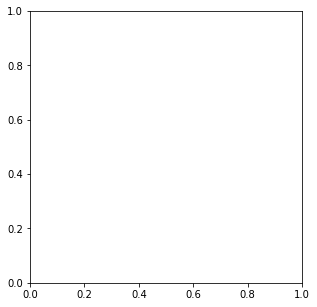

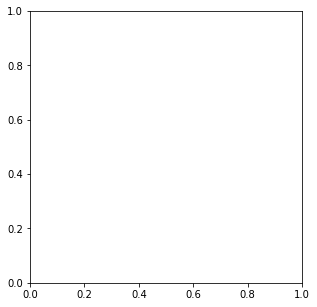

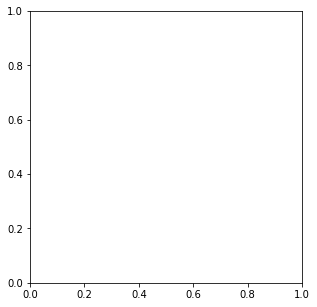

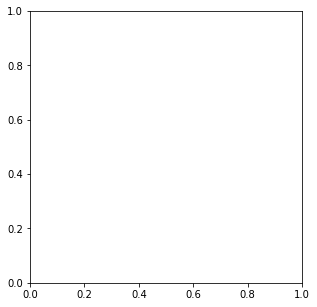

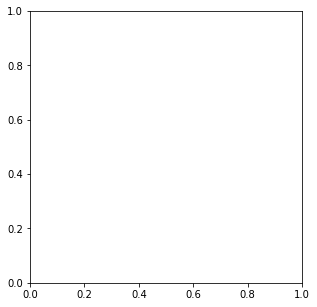

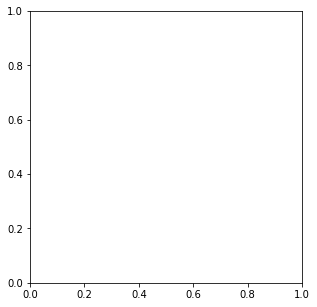

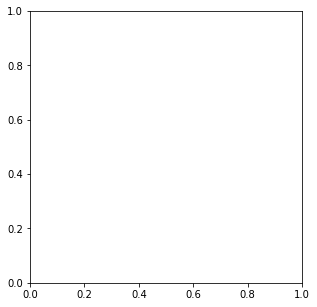

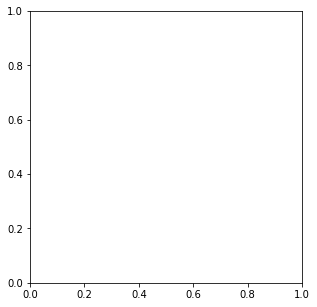

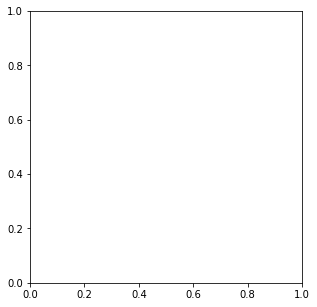

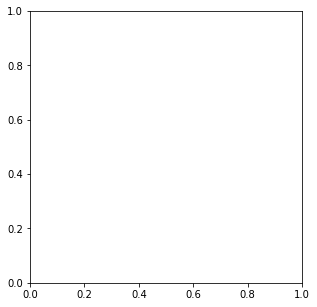

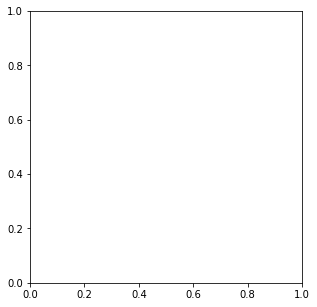

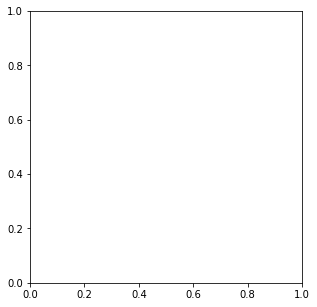

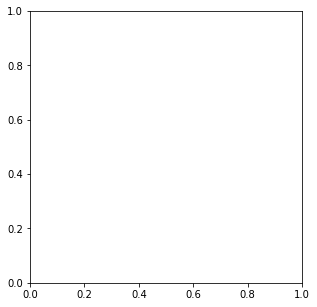

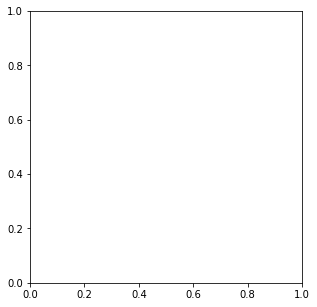

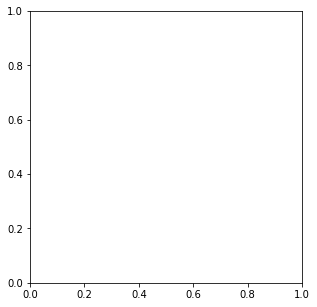

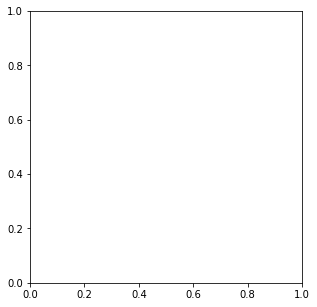

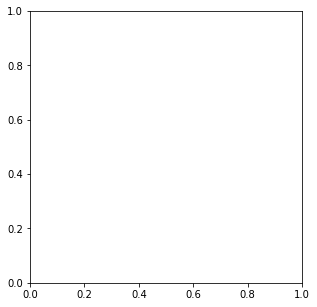

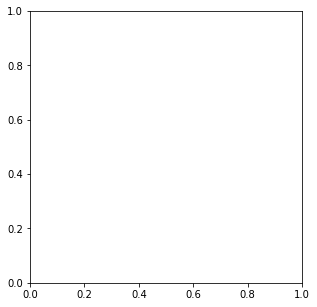

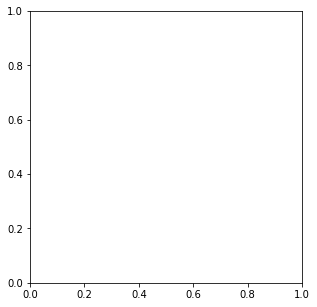

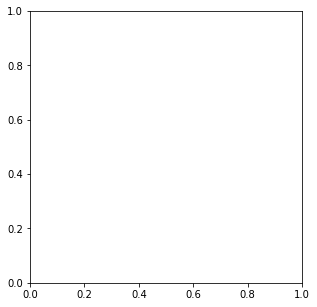

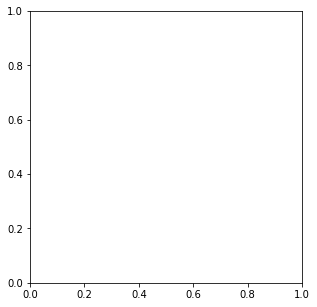

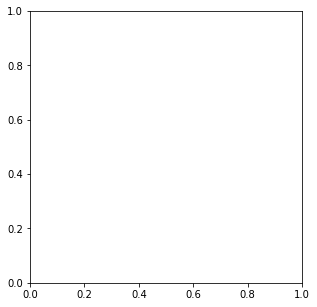

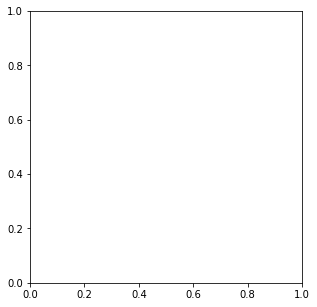

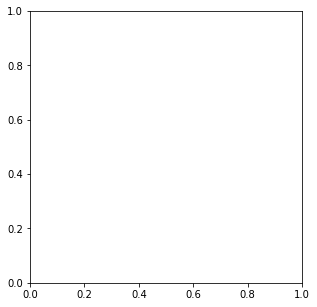

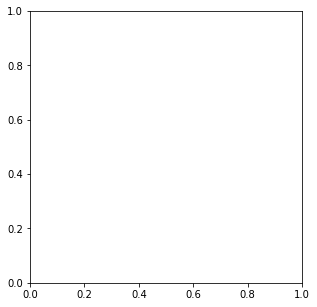

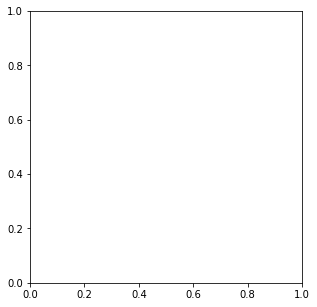

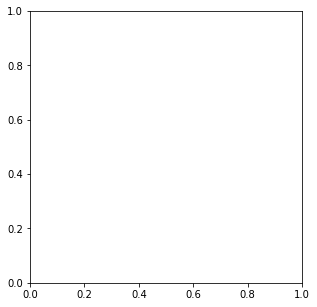

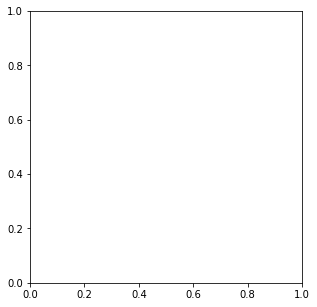

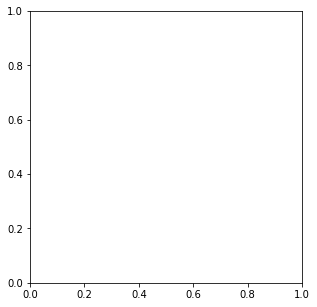

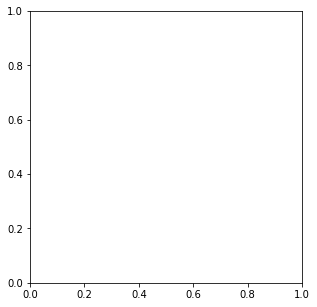

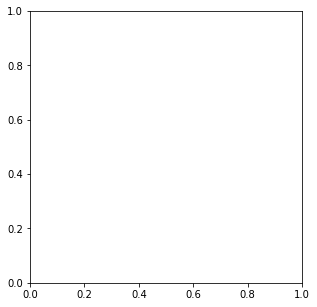

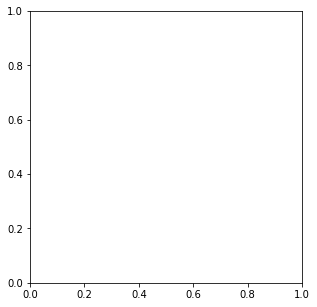

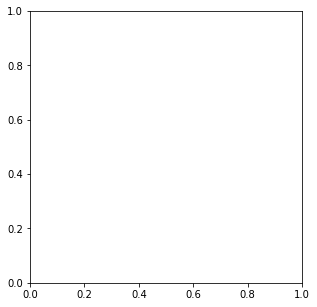

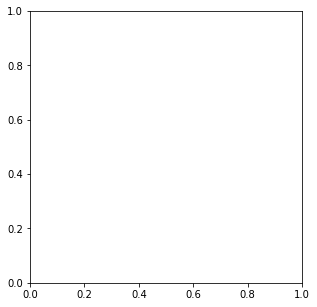

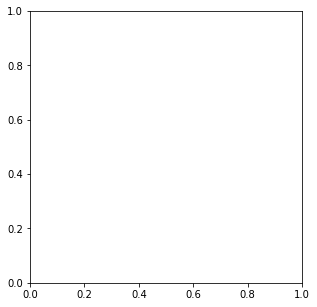

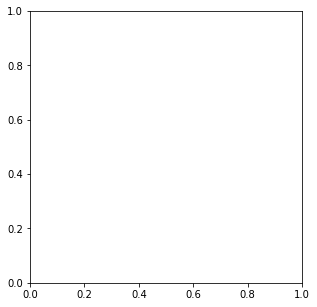

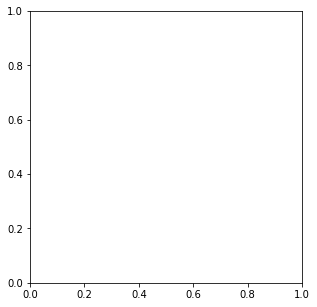

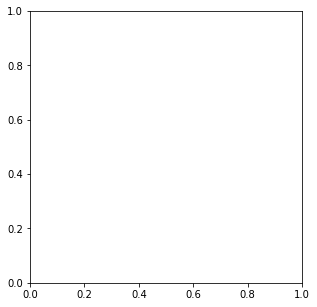

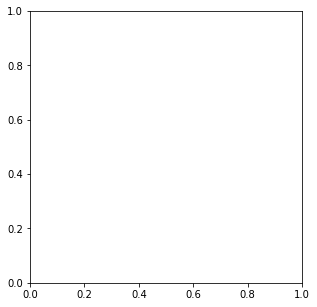

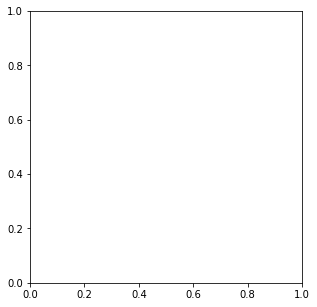

In [14]:
#Experiment 2
trial_description = 'Validating first agent on new, second, environment'
trial_name = '1st agent validation - Flip left and right'
project_name = "learning-by-hacking"
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 200000, #irrelevent here
    "env_name": "Baseline 2",
    "ROOM_SIZE": 9,
    "BALL_COLOR": "green",
    "2ND_BALL_COLOR": "green",
    "TILE_SIZE": 8,
    "Trial description": trial_description
}

validate_baseline(trial_description, trial_name, config, modelName = "first_agent", randomColor = False)

In [11]:
#Experiment 3
trial_description = 'Validating second agent on new, second, environment, along with logging of the training'
trial_name = '2nd agent training and validation - flip left and right'
project_name = "learning-by-hacking"
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 200000,
    "env_name": "2nd environment",
    "ROOM_SIZE": 9,
    "BALL_COLOR": "green",
    "2ND_BALL_COLOR": "green",
    "TILE_SIZE": 8,
    "Trial description": trial_description}

train_2nd_agent_and_validate(trial_description, trial_name, config, modelName = "first_agent", randomColor = False, log_wb=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


loaded: gamma = 0.99 n_steps = 2048
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_agent_tb/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.5     |
|    ep_rew_mean     | 0.968    |
| time/              |          |
|    fps             | 154      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 0.97        |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011902378 |
|    clip_fraction        | 0.171       |
|    clip_range           | 

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Error: gif - No such file or directory.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,█▅▅▆▃▃▂▂▂▃▄▄▃▂▂▁▃▁▂▂▂▄▂▂▁▂▄▃▃▂▂▂▂▁▃▁▃▃▂▂
rollout/ep_rew_mean,▁▄▄▃▆▆▇▇▇▆▅▅▆▇▇█▆█▇▇▇▅▇▇█▇▅▆▆▇▇▇▇█▆█▆▆▇▇
time/fps,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▁▂▄▅▆▇▆▅▅▆▇▆▇▅▆▅▇▇▆▆▇▅▆▅▆▇▆▆▆▆▇▇▅▅▇▄▇█▅▆
train/clip_fraction,▁▆██▇▆▅▃▄▄▄▄▄▃▃▄▄▄▄▃▃▄▃▃▃▃▃▂▃▃▂▃▃▃▄▂▃▃▃▂
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇
train/explained_variance,▁▅▆▇▇▇▇▇▇▇▇▇▇█▇██████▇██████████▇███████
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▄▁▁▂▃▃▂▂▂▂▃▄▄▄▃▄▃▃▂▃▃▃▃▄▄▂▃▅▄▅▂█▃▃▃▄▄▂▂▃
